In [159]:
import os
from decimal import Decimal
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pdb
import numpy as np
from scipy.integrate import nquad
from scipy.interpolate import interp1d
import scipy.spatial as ss
import time
from matplotlib import colors
import random
from scipy.integrate import nquad
from scipy.interpolate import interp1d
import random
from scipy.interpolate import interpn
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#####initialize some functions####

#load input points and differential cross sections
def getpoints():
#     with open('diff_xsecs_a1_iso_new.txt') as ff:
    with open('diffxsec-xsec-a1_PDF4LHC21_mc_iso.txt') as ff:
        lines = ff.readlines()
        x_list = np.array([float(lines[ii+1].split()[0]) for ii in np.arange(len(lines)-1)])
        y_list = np.array([float(lines[ii+1].split()[1]) for ii in np.arange(len(lines)-1)])
        Q2_list_gev2 = np.array([float(lines[ii+1].split()[2]) for ii in np.arange(len(lines)-1)])

        #prefactor for previous definition of xsec. No longer used but keeping for posterity
        #change prefactor to 1
        prefactor = 1
        xsecnu_invgev2 = prefactor * np.array([float(lines[ii+1].split()[3]) for ii in np.arange(len(lines)-1)])
        xsecnub_invgev2 = prefactor * np.array( [float(lines[ii+1].split()[4]) for ii in np.arange(len(lines)-1)])

    #organize into 3D matrix (for interpolation)    
    xu = np.unique(x_list);yu = np.unique(y_list);qu = np.unique(Q2_list_gev2);
    dsigmanu_dxdy = np.zeros(shape=(10,10,10));dsigmanub_dxdy = np.zeros(shape=(10,10,10))
    count = 0
    for ix,x in enumerate(xu):
        for iy,y in enumerate(yu):
            for iq,q in enumerate(qu):
                dsigmanu_dxdy[ix,iy,iq] = xsecnu_invgev2[count]
                dsigmanub_dxdy[ix,iy,iq] = xsecnub_invgev2[count]
                count +=1



    #write interpolating function
    #yadism outputs d2sigma/dx/dq2 
    points = (xu,yu,qu)
    return points, dsigmanu_dxdy, dsigmanub_dxdy
    
def dsigmanudxdq2_interp_invgev2(x,y,q2): 
    points,dsigmanu_dxdy, dsigmanub_dxdy = getpoints()
    return interpn(points,dsigmanu_dxdy,(x,y,q2), bounds_error=False, fill_value=0)


def dsigmanubdxdq2_interp_invgev2(x,y,q2):
    points,dsigmanu_dxdy, dsigmanub_dxdy = getpoints()
    return interpn(points,dsigmanub_dxdy,(x,y,q2), bounds_error=False, fill_value=0)   

    #write dsigmadxdy = dsigmadxdq2 * dq2 / dy
def dsigmanudxdy_interp_invgev2(x,y,q2):
    E_nu = q2 / (2 * y * m_N * x)
    jacobian = 1 * (2 * E_nu * m_N * x)
    return dsigmanudxdq2_interp_invgev2(x,y,q2) * jacobian

def dsigmanubdxdy_interp_invgev2(x,y,q2):
    E_nu = q2 / (2 * y * m_N * x)
    jacobian = 1 * (2 * E_nu * m_N * x)
    return dsigmanubdxdq2_interp_invgev2(x,y,q2) * jacobian
    
#specify experiment {FASERv, FASERv2, FLArE10, FLArE100,AdvSND}
#gives neutrino flux (dN vs E) at experiment for neutrino with flavor {ve,vmu,vtau} = {12,14,16}
def dn_de(experiment,neutrino, raw = 0):
    if ('optimistic' in experiment) | ('nocuts' in experiment) | ('best' in experiment):
        experiment = experiment.split('_')[0]
    folder = os.path.join('Fluxes',experiment);L = os.listdir(folder)
    file = [f for f in L if '_'+str(neutrino) in f and 'CC' not in f];file = os.path.join(folder,file[0])
    with open(file) as f:
        lines=f.readlines()
        e_gev = np.array([float(lines[ii].split()[0]) for ii in np.arange(len(lines))])
        N_perbin = np.array([float(lines[ii].split()[1]) for ii in np.arange(len(lines))])
        
    #energies are evenly log10spaced. get dn_de by dividing by bin width
    width = e_gev * (e_gev[2]/e_gev[1] - 1)
    dnde_invgev = N_perbin / width
    if raw ==1:
        return e_gev, N_perbin
    else:
        return e_gev, dnde_invgev
    
############################

#what is proton density and length of each experiment?
def experiment_nL(experiment):
    if ('optimistic' in experiment) | ('nocuts' in experiment) | ('best' in experiment):
        experiment = experiment.split('_')[0]
    experiments = ['FASERv', 'FASERv2', 'FLArE10', 'FLArE100','AdvSND']
    index = experiments.index(experiment)
    Na = 6.02e23
    Z_Ar = 18;g_per_cm3_Ar = 1.4;MM_Ar = 39.9
    Z_W = 74;g_per_cm3_W = 19.3;MM_W = 183
    
    #density / Molar Mass * Avogardo * Z = protons / cm^3
    tungsten_proton_density = g_per_cm3_W / MM_W * Na * Z_W 
    LAr_proton_density = g_per_cm3_Ar / MM_Ar * Na * Z_Ar
    
    #density / Molar Mass * Avogardo * Atomic Weight = nucleons / cm^3
    tungsten_nucleon_density = g_per_cm3_W / MM_W * Na * MM_W 
    LAr_nucleon_density = g_per_cm3_Ar / MM_Ar * Na * MM_Ar
    
    #fasernu, SND are tungsten, Flare is liquid argon.
    proton_densities_percm3 = [tungsten_proton_density,tungsten_proton_density,LAr_proton_density,LAr_proton_density,tungsten_proton_density]
    nucleon_densities_percm3 = [tungsten_nucleon_density,tungsten_nucleon_density,LAr_nucleon_density,LAr_nucleon_density,tungsten_nucleon_density]
    
    #Experimental lengths in cm. (What is AdvSND length? I set to zero for now)
    lengths_cm = np.array([1,2,7,30,6])*100
    return nucleon_densities_percm3[index],lengths_cm[index]


######Some Common Functions################

# Enu_array = EH_array + El_array
# Q2_array = 4*Enu_array*El_array*np.sin(theta_array/2)**2
# x_array = Q2_array / (2 * m_N * (Enu_array - El_array))
# y_array = Q2_array / (2 * m_N * Enu_array * x_array)
#calculates observables, theta,El,Eh from kinematics x,q2,Enu,y
#returns theta,El,Eh
def obs_from_kin(x,q2,Enu):
    m_N = 0.938
    y = q2 / (2 * m_N * Enu *x)
    Elepton = Enu*(1-y)
    Ehadron = Enu - Elepton
    sin2_theta_2 = q2 / (4 * Enu * Elepton);theta = 2 * np.arcsin(np.sqrt(sin2_theta_2))
    return theta[~np.isnan(theta)],Elepton[~np.isnan(theta)],Ehadron[~np.isnan(theta)],y[~np.isnan(theta)]
#     return theta,Elepton,Ehadron,y

#returns x_array,q2_array,Enu_array from observables theta,El,Eh
def kin_from_obs(theta_array,Elepton_array,Ehadron_array):
    m_N = 0.938
    Enu_array = Elepton_array + Ehadron_array
    q2_array = 4 * Enu_array * Elepton_array * np.sin(theta_array / 2)**2
    x_array = q2_array / (2 * m_N * (Enu_array - Elepton_array))
    return x_array,q2_array, Enu_array
    
#given bins in x,q2,Enu,N gives random uniform array 
#returns x,q2,Enu
def get_uniform_array(x_bin,q2_bin,Enu_bin,N):
    x_array = np.random.uniform(low = x_bin[0],high = x_bin[1],size = N)
    q2_array = np.random.uniform(low = q2_bin[0],high = q2_bin[1],size = N)
    Enu_array = np.random.uniform(low = Enu_bin[0],high = Enu_bin[1],size = N)
#     Enu_array = np.random.uniform(low = np.log10(Enu_bin[0]) , high = np.log10(Enu_bin[1]),size = N);Enu_array = 10**Enu_array; 
    return x_array,q2_array,Enu_array

#make cuts and return allowed terms x_cut,q2_cut,Enu_cut    
def make_cuts(x_array,q2_array,Enu_array,info = 0):
    m_N = 0.938
    y_array = q2_array / (2 * m_N * Enu_array * x_array)
#     locs = np.where((y_array > 0 ) & (y_array < 1) & (x_array > 0) & (x_array < 1) & (Enu_array > 0) & (Enu_array < 6000 & (q2_array > 4))
    locs = np.where((y_array > 0 ) & (y_array < 1) & (x_array > 0) & (x_array < 1) & (Enu_array > 0) & (q2_array > 0))

    x_cut = x_array[locs];q2_cut = q2_array[locs];Enu_cut = Enu_array[locs];
#     pdb.set_trace()
    if info ==1:
        print('Length of x and x')
        print(len(x_cut),x_cut,len(locs[0]))
    return x_cut,q2_cut,Enu_cut

#takes experiment,neutrino,theta,Elepton,Ehadron,
#returns smeared: theta,El,Eh
def smear_obs(experiment,neutrino,theta_array,Elepton_array,Ehadron_array,debug = 0,smear_corr = ''):
    deltheta,delEl,delEh = delta_exp(experiment,neutrino)
    if smear_corr =='theta':
        delEl = 0; delEh = 0
    elif smear_corr =='Elepton':
        deltheta = 0;delEh = 0
    elif smear_corr =='Ehadron':
        deltheta = 0;delEl = 0
    elif smear_corr not in ['theta','Elepton','Ehadron' , '']:
        raise('The observable you are smearing is not in the list')
    if debug ==1:
        pdb.set_trace()
    
    new_theta_array = np.random.normal(loc = theta_array,scale = deltheta)
    new_El_array = np.random.normal(loc = Elepton_array,scale = delEl * Elepton_array)
    new_Eh_array = np.random.normal(loc = Ehadron_array,scale = delEh * Ehadron_array)
    return new_theta_array,new_El_array,new_Eh_array

def smear_obs_from_kin(experiment,neutrino,x_array , q2_array , Enu_array,smear_corr = ''):
    theta_array , Elepton_array , Ehadron_array , y_array = obs_from_kin(x_array , q2_array , Enu_array);
    theta_array , Elepton_array , Ehadron_array = smear_obs(experiment,neutrino,theta_array , Elepton_array , Ehadron_array,smear_corr = smear_corr)
    x_array,q2_array, Enu_array = kin_from_obs(theta_array,Elepton_array,Ehadron_array)
    return x_array , q2_array , Enu_array

#takes experiment,neutrino, theta,Elepton,Ehadron and makes experimental cuts
#returns theta,Elepton,Ehadron
def make_exp_cuts(experiment,neutrino,theta_array,Elepton_array,Ehadron_array):
    Ehmin,Ehmax,thetamin,thetamax,Elmin,Elmax = thresholds(experiment,neutrino)
    locsH = np.where((Ehadron_array > Ehmin) & (Ehadron_array < Ehmax))
    locsL = np.where((Elepton_array > Elmin) & (Elepton_array < Elmax))
    locsT = np.where((theta_array > thetamin) & (theta_array < thetamax))
#     pdb.set_trace()
    locs = np.intersect1d(locsH,np.intersect1d(locsL,locsT))
#     print(locsH,locsL,locsT,locs)
    
    return theta_array[locs],Elepton_array[locs],Ehadron_array[locs]

def make_exp_cuts_from_kin(experiment,neutrino,x_array,q2_array,Enu_array):
    theta,El, Eh,y = obs_from_kin(x_array,q2_array,Enu_array)
    theta,El,Eh = make_exp_cuts(experiment,neutrino,theta,El,Eh)
    x,q2,Enu = kin_from_obs(theta,El,Eh)
    return x,q2,Enu

def delta_exp(experiment,neutrino):
    if (experiment == 'FASERv2') | (experiment =='FASERv') | (experiment =='FASERv2_nocuts'):# | (experiment == 'FASERv2_optimistic'):
        deltheta,delEl,delEh = 1e-3,0.15,0.5
    elif (experiment == 'FASERv2_optimistic') | (experiment =='FASERv_optimistic'):
        deltheta,delEl,delEh = 1e-3/2 , 0.3/2 , 0.5/2
    elif experiment =='FASERv2_best':
        deltheta,delEl,delEh = 0 , 0 , 0
    elif experiment == 'FLArE10':
        if np.abs(neutrino) == 14:#muon
            deltheta,delEl,delEh = 15e-3,0.05,0.3
        elif np.abs(neutrino) == 12:#electron
            deltheta,delEl,delEh = 15e-3,0.05,0.3
    elif experiment == 'AdvSND':
        deltheta,delEl,delEh = 1e-3,0.1,0.1
    return deltheta,delEl,delEh

def thresholds(experiment,neutrino):
#     print('Flare only valid for muon neutrinos')
    if (experiment == 'FASERv2') | (experiment =='FASERv') | (experiment == 'FASERv2_optimistic') | (experiment =='FASERv_optimistic')| (experiment =='FASERv_best'):
        #treat minimum as same for lepton, max is maximum of neutrino energy
        EH_min = 100;EH_max = 10e3
        theta_min = 0;theta_max = np.arctan(0.5)
        El_min = 100;El_max = 10e3
    elif experiment =='FASERv2_nocuts':
        EH_min = 0;EH_max = np.inf
        theta_min = 0;theta_max = np.pi
        El_min = 0;El_max = 5698
    elif experiment =='FLArE10':
        if np.abs(neutrino) == 14:#muon
            El_min = 10e-3;El_max = 2;
            theta_min = 0;theta_max = 0.4
            EH_min = 10e-3;EH_max = 6e3
        elif np.abs(neutrino) == 12:#electron
            El_min = 10e-3;El_max = 1e3
            theta_min = 0;theta_max = 0.5
            EH_min = 10e-3;EH_max = 6e3
    elif experiment =='AdvSND':
        EH_min = 20;EH_max = 6e3
        theta_min = 0;theta_max = 0.15
        El_min = 20;El_max = 6e3
    return EH_min,EH_max,theta_min,theta_max,El_min,El_max

def locsinside(Bin,Array):
    locs = np.where((Array <= Bin[1]) & (Array >= Bin[0]))
    return locs

def getf(experiment,neutrino):  
    m_N = 0.938
    anti = 1 if neutrino < 0 else 0;
    e_gev,dnde_invgev = dn_de(experiment,neutrino);
    dn_de_interp = interp1d(e_gev,dnde_invgev,fill_value = 0)

    #write g function for x, y, E_nu binning. 
    if anti == 0:
        def f(x,Enu,q2):
            y = q2/(2*m_N*Enu*x)
#             print(Enu,y,x,q2)
            return dn_de_interp(Enu) * dsigmanudxdq2_interp_invgev2(x,y,q2)
    elif anti ==1:
        def f(x,Enu,q2):
            y = q2/(2*m_N*Enu*x)
            return dn_de_interp(Enu) * dsigmanubdxdq2_interp_invgev2(x,y,q2) 
    return f

def get_kin_inside(x_bin , q2_bin , Enu_bin , x_array , q2_array , Enu_array):
    xlocs = locsinside(x_bin , x_array);qlocs = locsinside(q2_bin , q2_array);Elocs = locsinside(Enu_bin , Enu_array)
    locs = np.intersect1d(xlocs , np.intersect1d(qlocs , Elocs))
    return x_array[locs] , q2_array[locs] , Enu_array[locs]
#############################3

######## Saving and Writing###########

def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)
        
def line_prepender2(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)
        
def file_saver(D_array,xavg_array,Q2avg_array,Enuavg_array,variance_array  ,fraction_variance_theta, fraction_variance_Elepton,fraction_variance_Ehadron, sample_array,x_edges,Q2_edges,Enu_edges,stringsave,neutrino):
    plot_all_bins = 1
    if neutrino < 0:
        sigma = dsigmanubdxdq2_interp_invgev2
    else:
        sigma = dsigmanudxdq2_interp_invgev2
    
    #loop over
    myfile = open(stringsave,'w')
    m_N = 0.938
    N_sum = 0
#     pdb.set_trace()
    myfile.write(
    f"{'x_lower':<15} {'x_upper':<15} {'x_avg':<15}"\
    f"{'Q2_lower[GeV^2]':<20} {'Q2_upper[GeV^2]':<20} {'Q2_avg[GeV^2]':<20}"\
    f"{'E_nu_lower[GeV]':<20} {'E_nu_upper[GeV]':<20} {'E_nu_avg[GeV]':<20}"\
    f"{'d^sigma/dxdQ2(x_avg,Q2_avg,Enu_avg) pb / GeV^2':<55}"\
    f"{'N_events':<15} {'N_events_errs = Sqrt[N_events]':<34} {'N_sys_errs':<20}"\
    f"{'Percent_error_theta': <25} {'Percent_error_Elepton': <25}"\
    f"{'Percent_error_Ehadron' : <25}"\
    f"{'MC_Samples'} \n")
    
    for ix,x_lower in enumerate(x_edges[:-1]):
            for iq,q2_lower in enumerate(Q2_edges[:-1]):
                for ie,E_lower in enumerate(Enu_edges[:-1]):
                    #get upper bins values
                    x_upper,q2_upper,E_upper = x_edges[ix+1],Q2_edges[iq+1],Enu_edges[ie+1]
                    
                    #calculate relevant quantities
                    #first calculate averages along axis
                    xavg = np.mean(xavg_array[ix,iq,ie,0:])
                    q2avg = np.mean(Q2avg_array[ix,iq,ie,0:])
                    Enuavg = np.mean(Enuavg_array[ix,iq,ie,0:])
                    yavg = q2avg / (2 * m_N * Enuavg * xavg)
                    
                    
                    if yavg >1 or np.isnan(yavg):
                        dsigma_mid = np.nan
                    else:
                        try:
                            dsigma_mid = sigma(xavg,yavg,q2avg)
                        except:
                            print(xavg,yavg,q2avg)
                            raise('error')
                    N_here = np.mean(D_array[ix,iq,ie,0:])
                    sys_error = np.mean(variance_array[ix,iq,ie,0:])
#                     fraction_variance_here = np.mean(fraction_variance_array[ix,iq,ie,0:])
                    fraction_variance_theta_here = np.mean(fraction_variance_theta[ix,iq,ie,0:])
                    fraction_variance_Elepton_here = np.mean(fraction_variance_Elepton[ix,iq,ie,0:])
                    fraction_variance_Ehadron_here = np.mean(fraction_variance_Ehadron[ix,iq,ie,0:])
                    
                    
                    N_sum += N_here
                    Nsamples = np.sum(sample_array[ix,iq,ie,0:])

                    #not really MC error,statistical error
                    MC_error = np.sqrt(N_here)
                    
                    #save
                    if ((np.nan_to_num(N_here)>0) | (plot_all_bins==1)):
                        myfile.write(
                        f"{format(x_lower, '.6e'):<15} {format(x_upper, '.6e'):<15} {format(xavg, '.6e'):<15}"\
                        f"{format(q2_lower, '.6e'):<20} {format(q2_upper, '.6e'):<20} {format(q2avg, '.6e'):<20}"\
                        f"{format(E_lower, '.6e'):<20} {format(E_upper, '.6e'):<20} {format(Enuavg, '.6e'):<20}"\
                        f"{format(float(dsigma_mid), '.6e'):<55}"\
                        f"{format(float(np.nan_to_num(N_here)), '.6e'):<15} {format(float(MC_error), '.6e'):<34} {format(float(sys_error), '.6'):<20}"\
                        f"{format(float(fraction_variance_theta_here), '.6'):<25} {format(float(fraction_variance_Elepton_here), '.6'):<25}"\
                        f"{format(float(fraction_variance_Ehadron_here), '.6'):<25}"\
                        f"{format(Nsamples, '.6e')} \n"\
                        )
                    else:
                        print('here')
    return N_sum

def file_saver_clip(header , stringsave , x_lower , x_upper , x_avg , q2_lower , q2_upper , q2_avg , Enu_lower , Enu_upper , Enu_avg , diffxsec , N , stat_error , sys_error  ,fraction_variance_theta, fraction_variance_Elepton,fraction_variance_Ehadron,  MCsamples):
#     myfile = open(stringsave,'w')
    myfile = open(stringsave , 'w')
    myfile.write(header)
    myfile.write(
    f"{'x_lower':<15} {'x_upper':<15} {'x_avg':<15}"\
    f"{'Q2_lower[GeV^2]':<20} {'Q2_upper[GeV^2]':<20} {'Q2_avg[GeV^2]':<20}"\
    f"{'E_nu_lower[GeV]':<20} {'E_nu_upper[GeV]':<20} {'E_nu_avg[GeV]':<20}"\
    f"{'d^sigma/dxdQ2(x_avg,Q2_avg,Enu_avg) pb / GeV^2':<55}"\
    f"{'N_events':<15} {'N_events_errs = Sqrt[N_events]':<34} {'N_sys_errs':<20}"\
    f"{'Percent_error_theta': <25} {'Percent_error_Elepton': <25}"\
    f"{'Percent_error_Ehadron' : <25}"\
    f"{'MC_Samples'} \n")
    for xl , xu , xa, q2l , q2u , q2a, Enul , Enuu , Enua, dx , NN , stat , sys ,sys_frac_theta,sys_frac_Elepton,sys_frac_Ehadron,samples in\
    zip(x_lower , x_upper , x_avg , q2_lower , q2_upper , q2_avg , Enu_lower , Enu_upper , Enu_avg , diffxsec , N , stat_error , sys_error  ,fraction_variance_theta, fraction_variance_Elepton,fraction_variance_Ehadron, MCsamples):
            myfile.write(\
            f"{format(xl, '.6e'):<15} {format(xu, '.6e'):<15} {format(xa, '.6e'):<15}"\
            f"{format(q2l, '.6e'):<20} {format(q2u, '.6e'):<20} {format(q2a, '.6e'):<20}"\
            f"{format(Enul, '.6e'):<20} {format(Enuu, '.6e'):<20} {format(Enua, '.6e'):<20}"\
            f"{format(float(dx), '.6e'):<55}"\
            f"{format(NN, '.6e'):<15} {format(stat, '.6e'):<35}"\
            f"{format(sys, '.6'):<20}"\
            f"{format(float(sys_frac_theta), '.6'):<25} {format(float(sys_frac_Elepton), '.6'):<25}"\
            f"{format(float(sys_frac_Ehadron), '.6'):<25}"\
            f"{format(samples, '.6e')} \n"\
            )

#function to go through and save to .txt in same fashion. Have D_



#returns x_lower,x_upper,q2_lower,q2_upper,N,stat error,sys error in array format of same length
def file_reader(experiment,name,smear_corr='',clipped = 0):

        
        
    x_edges = np.logspace(-4,0,30)
    Q2_edges = np.array([4,10**1,10**2,10**3,10**4,10**5])
    ####################################################
    ####################################################
    #first parse data
    x_lower = np.array([])
    x_upper = np.array([])
    Enu_lower = np.array([])
    Enu_upper = np.array([])
    q2_lower = np.array([])
    q2_upper = np.array([])
    stat_error = np.array([])
    sys_error = np.array([])
    diffxsec = np.array([])
    N = np.array([])
    xavg = np.array([])
    qavg = np.array([])
    Enuavg = np.array([])
    xsec = np.array([])
    frac_variance = np.array([])
    frac_variance_theta = np.array([])
    frac_variance_Elepton = np.array([])
    frac_variance_Ehadron = np.array([])
    MCsamples = np.array([])
    
    if clipped == 0:
        readfile = os.path.join(os.getcwd(),name)
#         print(readfile)
        
        
    with open(readfile,'r') as f:
        lines = f.readlines()
        for il,line in enumerate(lines):
#             
            if il <= 1: 
                continue
            else:
                sp = line.split()
                try:
                    x_lower = np.append(x_lower,float(sp[0]));x_upper = np.append(x_upper,float(sp[1]))
                except:
                    pdb.set_trace()
                xavg = np.append(xavg,float(sp[2]));

                q2_lower = np.append(q2_lower,float(sp[3]));q2_upper = np.append(q2_upper,float(sp[4]))
                qavg = np.append(qavg, float(sp[5]))
                
                Enu_lower = np.append(Enu_lower , float(sp[6]));Enu_upper = np.append(Enu_upper , float(sp[7]))
                Enuavg = np.append(Enuavg , float(sp[8]))
                
                diffxsec = np.append(diffxsec , float(sp[9]))

                N = np.append(N,float(sp[10]))
                stat_error = np.append(stat_error,float(sp[11]))
                sys_error = np.append(sys_error,float(sp[12]))
                frac_variance_theta = np.append(frac_variance_theta , float(sp[13]))
                frac_variance_Elepton = np.append(frac_variance_Elepton , float(sp[14]))
                frac_variance_Ehadron = np.append(frac_variance_Ehadron , float(sp[15]))
                MCsamples = np.append(MCsamples , float(sp[16]))
                
    
#     return x_lower, x_upper, q2_lower,q2_upper,N,stat_error,sys_error
    return x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error  , frac_variance_theta,frac_variance_Elepton,frac_variance_Ehadron,MCsamples

In [150]:
#gnerate using rejection sampling: https://towardsdatascience.com/what-is-rejection-sampling-1f6aff92330d
def rej_sampling(experiment,neutrino,plot = 1, N = 1000000,makecuts = 1):
    Enu_choice_bin = [11.34,5697]
    x_choice_bin = [0.6e-3,1e0]
    q2_choice_bin = [4,1e4]
    m_N = 0.938
    anti = 0 if neutrino >0 else 1
    def phat(x,q2,Enu):
        n,L = experiment_nL(experiment)
        m_N = 0.938

        #interpolate to get dn_de
        e_gev,dnde_invgev = dn_de(experiment,neutrino);
        dn_de_interp = interp1d(e_gev,dnde_invgev,fill_value = 0,bounds_error=False)
        if anti == 0:
            y = q2/(2*m_N*Enu*x)
            return dn_de_interp(Enu) * dsigmanudxdq2_interp_invgev2(x,y,q2)
        elif anti ==1:
            y = q2/(2*m_N*Enu*x)
            return dn_de_interp(Enu) * dsigmanubdxdq2_interp_invgev2(x,y,q2) 


    #Now have proposal and target distribution function

    #Enu proposal one sided gaussian
    mu,sigma = 12,1500
    a, b = (Enu_choice_bin[0] - 12) / sigma, (Enu_choice_bin[1] - 12) / sigma
    EE = stats.truncnorm(a , b , loc = mu, scale = sigma);Enu_choice = EE.rvs(N);g1 = EE.pdf;
    
    #x proposal loguniform
    xx = stats.loguniform(x_choice_bin[0] , x_choice_bin[1]);x_choice = xx.rvs(N);g2 = xx.pdf

    #q^2 proposal loguniform
    qq = stats.loguniform(q2_choice_bin[0],q2_choice_bin[1]);q2_choice = qq.rvs(N);g3 = qq.pdf
    
    #write total PDF
    def g_pdf(x , q2 , Enu):
        return g1(Enu) * g2(x) * g3(q2);


    #explore space(not currently used)
#    xx = np.geomspace(x_choice_bin[0],x_choice_bin[1],100); yq = np.geomspace(q2_choice_bin[0],q2_choice_bin[1],99);ze = np.linspace(Enu_choice_bin[0],Enu_choice_bin[1],101);
#    X,Y,Z = np.meshgrid(xx,yq,ze);z = phat(X,Y,Z);
   
    #Evaluate proposal and target distributions
    target_array = phat(x_choice,q2_choice,Enu_choice)
    proposal_array = g_pdf(x_choice , q2_choice , Enu_choice)
    
    
    #calculate c, such that proposal function captures target function. Add on modifier which slows sampling rate, but ensures envelope
    modifier = 1.1
    c = modifier*np.max(target_array / proposal_array)
    u_check = np.random.uniform(0,1 , size = N)
    accept_locs = u_check * proposal_array * c < target_array
    
#     accept_locs = y_check < target_array

    if np.any(c * proposal_array < target_array ):
        print('not big enough constant!')
        print('Raise modifier')
        raise('error')

    #grab bins that pass
    x_accept = x_choice[accept_locs];q2_accept = q2_choice[accept_locs];Enu_accept = Enu_choice[accept_locs];
    
    print('Were experimental cuts made?',makecuts)
    
    #make experimental and kinematic cuts
    if makecuts ==1:
        x_accept , q2_accept , Enu_accept = make_exp_cuts_from_kin(experiment , neutrino , x_accept , q2_accept , Enu_accept)
        x_accept , q2_accept , Enu_accept = make_cuts(x_accept , q2_accept, Enu_accept)
    print('Acceptance rate and count:',len(x_accept) / len(x_choice),len(x_accept))
    #######Plotting##################
    #To see distribution of points
    if plot==1:
        fig,ax = plt.subplots(1,2,figsize = (16,6))
        # ax[0].hist2d(x_accept,q2_accept,bins = 100);
        x = np.geomspace(x_choice_bin[0],x_choice_bin[1],1000); y = np.geomspace(q2_choice_bin[0],q2_choice_bin[1],999);X,Y = np.meshgrid(x,y);z = phat(X,Y,np.mean(Enu_choice_bin));
        ax[0].pcolormesh(X,Y,z);ax[0].set_yscale('log');ax[0].set_xscale('log')

        im = ax[1].hist2d(x_accept,q2_accept,bins = 100);ax[1].set_yscale('log');ax[1].set_xscale('log');ax[1].set_xlim(ax[0].get_xlim());ax[1].set_ylim(ax[0].get_ylim());
        # plt.colorbar(im,cax = ax[1])
        plt.figure(figsize = (16,8))
        funplot = plt.pcolormesh(X,Y,z,alpha = 0.8,norm = colors.LogNorm(vmin = np.min(z[z>0]),vmax = np.max(z)));plt.yscale('log');plt.xscale('log');
        plt.xlabel('x')
        plt.ylabel('Q2')
        plt.title(r'Evaluating f(x,Q2,Enu)')
        ax = plt.gca()
        plt.colorbar()
        plt.figure(figsize = (16,8))
        
        a = np.histogram2d(x_accept,q2_accept,bins = 1000);aa = a[0]
        lower , upper = np.min(aa[aa>0]),np.max(aa)
        plt.hist2d(x_accept,q2_accept,bins = 500,alpha = 0.8,norm = colors.LogNorm(vmin = lower,vmax = upper));plt.yscale('log');plt.xscale('log');
        plt.xlim(ax.get_xlim());plt.ylim(ax.get_ylim())
        plt.title('Sampling from f(x,Q2,Enu), with experimental cuts')
        plt.colorbar()
    if plot == 0:
        return x_accept,q2_accept,Enu_accept,len(x_accept)
        

def sample_space(experiment , neutrino , Nloops = 20, N_sample = 10000000,makecuts = 1 ):
    expected_acceptance = 2 / 100;
    x_final = np.zeros(int(Nloops * N_sample*expected_acceptance) );q2_final = np.zeros_like(x_final);Enu_final = np.zeros_like(x_final)
    total_count = 0
    for loop_index in np.arange(Nloops):
        x,q2,Enu,spot_here = rej_sampling(experiment,neutrino,plot = 0,N = N_sample , makecuts = makecuts);
        x_final[total_count : total_count + len(x)] = x
        q2_final[total_count : total_count + len(x)] = q2
        Enu_final[total_count : total_count + len(x)] = Enu
        total_count += len(x)
    return x_final[0:total_count] , q2_final[0:total_count] , Enu_final[0:total_count]


def get_Ntotal(file):
    with open(file,'r') as f:
        lines = f.readlines()
        first_line = lines[0]
        totalevent_line = first_line.split('|')[5]
        events = totalevent_line.split(' ')[4]
        return float(events)
        
def get_string_process(neutrino):
    if neutrino > 0:
        return r'$\nu_{\mu} ~N \rightarrow \mu^- X$'
    elif neutrino <0:
        return r'$\bar{\nu}_{\mu} N \rightarrow \mu^+ X$'
    
def make_all_cuts(experiment , neutrino , x , q2 , Enu):
    x , q2 , Enu = make_cuts(x,q2 , Enu)
    x , q2 , Enu = make_exp_cuts_from_kin(experiment, neutrino , x,q2,Enu)
    return x, q2, Enu
    

def get_variance(experiment , neutrino , x_bin_select , q2_bin_select , Enu_bin_select , x_final , q2_final , Enu_final , smear_corr = '', loopcount = 3,debug = 0):
#     x_final_cut , q2_final_cut , Enu_final_cut = make_cuts(x_final , q2_final , Enu_final)
#     x_final_cut , q2_final_cut , Enu_final_cut = make_exp_cuts_from_kin(experiment , neutrino , x_final_cut , q2_final_cut , Enu_final_cut)
    
    locsx = locsinside(x_bin_select , x_final);locsq = locsinside(q2_bin_select , q2_final);locsEnu = locsinside(Enu_bin_select , Enu_final);
    locs0 = np.intersect1d(locsx , np.intersect1d(locsq , locsEnu))
    del locsx ,locsq ,locsEnu
    if debug == 1:
        x_aftercuts , q2_aftercuts , Enu_aftercuts = make_cuts(x_final[locs0] , q2_final[locs0] , Enu_final[locs0])
        x_aftercuts , q2_aftercuts , Enu_aftercuts = make_exp_cuts_from_kin(experiment , neutrino , x_aftercuts , q2_aftercuts , Enu_aftercuts)
        print(np.max(x_aftercuts),np.max(q2_aftercuts))
    if len(locs0) != 0:
        factor = np.zeros(loopcount)
        factor_debug = np.zeros(loopcount)
        for ii in np.arange(loopcount):
            x_smear , q2_smear , Enu_smear = smear_obs_from_kin(experiment , neutrino , x_final , q2_final , Enu_final , smear_corr = smear_corr)
            x_smear , q2_smear , Enu_smear = make_cuts(x_smear , q2_smear , Enu_smear)
            x_smear , q2_smear , Enu_smear = make_exp_cuts_from_kin(experiment, neutrino , x_smear , q2_smear , Enu_smear)
            
            locsx = locsinside(x_bin_select,x_smear);locsq = locsinside(q2_bin_select,q2_smear);locsEnu = locsinside(Enu_bin_select , Enu_smear)
            
            locs = np.intersect1d(locsx , np.intersect1d(locsq , locsEnu))
            factor[ii] = len(x_smear[locs]) / len(x_final[locs0])
            if debug ==1:
                factor_debug[ii] = len(x_smear[locs]) / len(x_aftercuts)
                

        return np.abs(1 - np.mean(factor))
    else: 
        return np.nan

In [151]:
#finally, 
def N_bin_alt(x_bins,Enu_bins,Q2_bins,experiment = 'FASERvf',neutrino=114,N = 1000000,total_xsec = 0,m_N = 0.938,check_points = 0,info = 0):
    #check if antineutrino
    
    #target mass and experiment. 0.938 for proton.
    invgev2_in_cm2 = 3.89e-28
    cm2_in_pb = 1e-36
    
    #get experimental geometry
    n,L = experiment_nL(experiment)
    

    #interpolate to get dn_de
    f = getf(experiment , neutrino)
    
    
    #generate random numbers in x,Enu,y     
    x_array , Q2_array , Enu_array = get_uniform_array(x_bins , Q2_bins , Enu_bins , N);x_array_0 = np.copy(x_array)
    x_array , Q2_array , Enu_array = make_cuts(x_array , Q2_array , Enu_array)
    x_array , Q2_array , Enu_array = make_exp_cuts_from_kin(experiment, neutrino ,x_array,Q2_array,Enu_array)

    locs = np.intersect1d(locsinside(x_bins , x_array) , np.intersect1d(locsinside(Enu_bins , Enu_array) , locsinside(Q2_bins , Q2_array) ))
    if len(locs) < len(x_array):
        raise('Something is wrong, all points should be inside!')

    integrand = f(x_array,Enu_array,Q2_array)

    if check_points == 1 :
        return x_array , Q2_array , Enu_array , locs
    
    #Tried to integrate with scipy as a further check, but scipy couldn't handle it. May return to later if have 
    check_int = 0;
    if check_int ==1 :
        import scipy.integrate
        sci_check = scipy.integrate.nquad(lambda x  , q2 , Enu: f(x , Enu , q2  ) , [x_bins, Enu_bins , Q2_bins] )
    
    xavg = np.mean(x_array);q2avg = np.mean(Q2_array);Enuavg = np.mean(Enu_array) 
    acceptance = len(x_array) / len(x_array_0)
    MCpoints = [x_array,Q2_array,Enu_array]
    
    #make sure there are enough points in the MC sample to calculate a volume. Currently ignore bins that have less than 5 events
    #TODO: incrase 5. Should be determined by precision. Right now, we have plenty of events in each bin
    if len(x_array) <= 5:
        volume = 0
        locs = np.array([[1]])
        return 0 , 0 , 0 , np.mean(x_bins) , np.mean(Q2_bins) , np.mean(Enu_bins)
    else:
        try:
            volume = ss.ConvexHull(np.transpose(MCpoints)).volume
        except:
            print('had an error calculating the volume')
            pdb.set_trace()
        #return some info if you want it
        if info == 1:
            print(x_bins , Q2_bins , Enu_bins)
            print( 'MC int:',sum(integrand) * volume / len(x_array[locs]) * n * L * cm2_in_pb)
            if check_int == 1:
                print('scipy' , sci_check[0]  * n * L * cm2_in_pb)
        return sum(integrand) * volume / len(x_array[locs]) * n * L * cm2_in_pb,acceptance,len(x_array),xavg,q2avg,Enuavg



In [152]:
def get_D(M,N,seed,experiment,neutrino,Nloops = 20,save = 0,check_points = 0,x_final = [] , q2_final = [] , Enu_final = [],save_folder = 'INCLUSIVE',append_save = 'inclusive',makecuts = 1):
# def get_D(M,N,seed,neutrino,save = 0):
##########################################
    np.random.seed(seed = seed)
    m_N = 0.938;
    n , L = experiment_nL(experiment)

    x_edges = np.logspace(-4,0,30)
    Q2_edges = np.array([4,10**1,10**2,10**3,10**4,10**5]);
    Enu_edges = np.logspace(np.log10(11.336355),np.log10(5698),2)
    
    del_theta,del_El,del_EH = delta_exp(experiment , neutrino)
    EH_min,EH_max,theta_min,theta_max,El_min,El_max = thresholds(experiment , neutrino)
    ##################Initialize###################
    D_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    xavg_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    Q2avg_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    Enuavg_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    sample_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    variance_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    
    fraction_variance_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    fraction_variance_Elepton = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    fraction_variance_Ehadron = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    fraction_variance_theta = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    
     
    ##############Sample space for variance##############
    if x_final == []:
        x_final , q2_final , Enu_final = sample_space(experiment , neutrino  ,Nloops= Nloops,makecuts = makecuts)
    ###############################################

    for im,m in enumerate(np.arange(M)):
        N_sum = 0
        for ix,x_lower in enumerate(x_edges[:-1]):
            for iq,q2_lower in enumerate(Q2_edges[:-1]):
                for ie,E_lower in enumerate(Enu_edges[:-1]):
                    #get upper of xbins
                    x_upper,q2_upper,E_upper = x_edges[ix+1],Q2_edges[iq+1],Enu_edges[ie+1]

                    #form xbins + MCdata
                    x_bin = [x_lower,x_upper];q2_bin = [q2_lower,q2_upper];Enu_bin = [E_lower,E_upper];

                    
                    #calculate from function: alt_sys : x , Enu , q2
                    try:
                        N_here,acceptance,Nsamples,_,_,_ = N_bin_alt(x_bin , Enu_bin , q2_bin , experiment = experiment , neutrino = neutrino , N = N)
                    except:
                        print('Had an Error:',x_bin,Enu_bin,q2_bin)
                        raise('error')
                        
                        
                    x_inside , q2_inside , Enu_inside = get_kin_inside(x_bin , q2_bin , Enu_bin , x_final , q2_final , Enu_final)
                    xavg , q2avg , Enuavg = np.mean(x_inside) , np.mean(q2_inside) , np.mean(Enu_inside)

                    D_array[ix,iq,ie,im] = N_here
                    xavg_array[ix,iq,ie,im] = xavg
                    Q2avg_array[ix,iq,ie,im] = q2avg
                    Enuavg_array[ix,iq,ie,im] = Enuavg
                    sample_array[ix,iq,ie,im] = Nsamples
                    
                    #get variance. Will only smear one variable if chosen
                    frac_variance = get_variance(experiment , neutrino , x_bin , q2_bin , Enu_bin , x_final , q2_final , Enu_final , smear_corr = '')
                    variance_array[ix,iq,ie,im] = N_here * frac_variance;
                    
                    fraction_variance_array[ix,iq,ie,im] = frac_variance
                    fraction_variance_theta[ix,iq,ie,im] = get_variance(experiment , neutrino , x_bin , q2_bin , Enu_bin , x_final , q2_final , Enu_final , smear_corr = 'theta')
                    fraction_variance_Elepton[ix,iq,ie,im] = get_variance(experiment , neutrino , x_bin , q2_bin , Enu_bin , x_final , q2_final , Enu_final , smear_corr = 'Elepton')
                    fraction_variance_Ehadron[ix,iq,ie,im] = get_variance(experiment , neutrino , x_bin , q2_bin , Enu_bin , x_final , q2_final , Enu_final , smear_corr = 'Ehadron')




                    #sum to get total event
                    N_sum += np.nan_to_num(N_here)

                    #get avg parameters and middle value
                    x_mid,q2_mid,Enu_mid = np.mean(x_bin),np.mean(q2_bin),np.mean(Enu_bin)
                    y_mid = q2_mid / (2 * m_N * Enu_mid * x_mid)
                    yavg = q2avg / (2 * m_N * Enuavg * xavg)
        print('Total Events in this step:',np.sum(D_array[:,:,:,im]))
    if save!=0:
        neutrino_string = 'nu' if neutrino > 0 else 'nub'
        stringsave = os.path.join(os.getcwd() , save_folder , '%s/nan_binned_sysevents_%s_%s_%s.txt' %(experiment,experiment,append_save,neutrino_string))
        file_saver(D_array,xavg_array,Q2avg_array,Enuavg_array,variance_array ,fraction_variance_theta, fraction_variance_Elepton,fraction_variance_Ehadron,sample_array,x_edges,Q2_edges,Enu_edges,stringsave,neutrino)
        
        summary_line = 'Experiment = %s | seed %s | Neutrino = %s | Exp. Target density (nucleons / cm3) = 10^(%0.1f) | Exp. Target Length = %0.0f cm | Total Events = %0.1f |\
        del_theta = %0.1f mrad, theta_max = %0.1f mrad |\
        del_Elepton = %0.1f %% , Elepton_min = %0.2f GeV, Elepton_max = %0.2f GeV|\
        del_Ehadron = %0.1f %%, Ehadron_min = %0.2f GeV GeV, Ehadron_max = %0.2f GeV'\
        %(experiment,str(seed), str(neutrino),np.log10(n),L,N_sum,del_theta*1e3,theta_max*1e3,del_El*1e2,El_min,El_max,del_EH*1e2,EH_min,EH_max) 

        line_prepender2(stringsave,summary_line)
        return x_final , q2_final , Enu_final

In [161]:
#This function generates events, samples the space, and calculates some files which are used for the covariance matrix
#The files produced with this will have plenty of nans
#2 sampling parameters to keep track of: {N and NLoops}
#N is the MC sampling and determines accuracy of expected event rate
#Nloops is how many times to sample data and determines accuracy of  event rate uncertainty
#I use N = 1000000 and N_loops = 20 which is an excess of what is required. Should be checked again for other experiments
#M is not currently used but is operable if needed. Will produce M independent runs of dataset. Useful for evaluating stability and sufficient MC sampling

#This function will take a while to run...
def run_events(experiment,save_folder = 'INCLUSIVE',append_save = 'inclusive'):
    for neutrino in [14 , -14]:
        #sample data and get event rate. N_loops is needed here.
        x_final , q2_final , Enu_final = get_D(1,100000,1,experiment,neutrino,save = 1 , Nloops = 10,save_folder = save_folder,append_save = append_save,makecuts = 1);
        
run_events('FASERv2',save_folder = 'INCLUSIVE',append_save = 'inclusive')

Were experimental cuts made? 1
Acceptance rate and count: 0.0104782 104782


C:\Users\Mhfie\AppData\Local\Temp/ipykernel_30784/2216108502.py:138: RuntimeWarning: invalid value encountered in arcsin
  sin2_theta_2 = q2 / (4 * Enu * Elepton);theta = 2 * np.arcsin(np.sqrt(sin2_theta_2))


Were experimental cuts made? 1
Acceptance rate and count: 0.0105139 105139
Were experimental cuts made? 1
Acceptance rate and count: 0.0105509 105509
Were experimental cuts made? 1
Acceptance rate and count: 0.0105223 105223
Were experimental cuts made? 1
Acceptance rate and count: 0.0104667 104667
Were experimental cuts made? 1
Acceptance rate and count: 0.0105206 105206
Were experimental cuts made? 1
Acceptance rate and count: 0.0104625 104625
Were experimental cuts made? 1
Acceptance rate and count: 0.010412 104120
Were experimental cuts made? 1
Acceptance rate and count: 0.0105049 105049
Were experimental cuts made? 1
Acceptance rate and count: 0.0105337 105337
Total Events in this step: 114652.82193914022
Were experimental cuts made? 1
Acceptance rate and count: 0.0149176 149176
Were experimental cuts made? 1
Acceptance rate and count: 0.0149373 149373
Were experimental cuts made? 1
Acceptance rate and count: 0.0149658 149658
Were experimental cuts made? 1
Acceptance rate and coun

# clip and covariance 

In [162]:
def get_nanlocs(file_array,experiment,save_folder = 'INCLUSIVE',event_minimum = 0,nocharge = 0):
    header_array  = ['' for x in np.arange(len(file_array))]
    print('Cutting Events below',event_minimum)
    N_summation = 0
    for file_index , file in enumerate(file_array):
        file = os.path.join(os.getcwd() , save_folder ,experiment, file)
        
        x_lower , _ , xavg , _ , _ , _ , _ , _ , _ , _ , N , _ , _ , _  , _ , _ , _ = file_reader(experiment,file)
        index = np.arange(len(x_lower))
        N_summation += N
        locs = ~np.isnan(xavg);
        
        if file_index == 0:
            location_array = np.arange(len(xavg))
            locs0 = np.copy(locs)
#             print(location_array[locs],location_array[locs],np.intersect1d(location_array[locs],locsE))
        else:
            locs0 = np.intersect1d(location_array[locs] , location_array[locs0])
    locsE = N_summation > event_minimum
    locs_final = np.intersect1d(location_array[locs0] , location_array[locsE])
    return location_array[locs_final]

def clip_nans(file_array , locs,experiment,nocharge = 0,save_folder = 'INCLUSIVE',append_save = 'inclusive'):
    if nocharge == 0:
        for file_index , file in enumerate(file_array):
            #naming
            file_pre = file.split('_')
            file_save = 'clipped_' + '_'.join(file_pre)
#             print(file_save)
            stringsave = os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_save)
            file_read = os.path.join(os.getcwd() , save_folder , experiment , file)

            neutrino = file.split('_')[-1:][0].split('.')[0]
            x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , frac_sys_theta , frac_sys_Elepton , frac_sys_Ehadron , MCsamples = file_reader(experiment,file_read)
            with open(file_read) as f:
                header = f.readline()

            file_saver_clip(header , stringsave , x_lower[locs] , x_upper[locs] , xavg[locs] , q2_lower[locs] , q2_upper[locs] , qavg[locs] , Enu_lower[locs] , Enu_upper[locs]\
            , Enuavg[locs] , diffxsec[locs] , N[locs] , stat_error[locs] , sys_error[locs] , frac_sys_theta[locs] , frac_sys_Elepton[locs] , frac_sys_Ehadron[locs] , MCsamples[locs])
    elif nocharge == 1:
        for file_index , file in enumerate(file_array):
            #naming
            file_pre = file.split('.')
            file_save = 'clipped_' + file_pre[0] + '_nochargediscrimination.txt'
#             print(file_save)
            stringsave = os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_save)
            file_read = os.path.join(os.getcwd() , save_folder , experiment , file)
            
            neutrino = 'nochargediscrimination'
            x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , frac_sys_theta , frac_sys_Elepton , frac_sys_Ehadron , MCsamples = file_reader(experiment,file_read)
            with open(file_read) as f:
                header = f.readline()

            file_saver_clip(header , stringsave , x_lower[locs] , x_upper[locs] , xavg[locs] , q2_lower[locs] , q2_upper[locs] , qavg[locs] , Enu_lower[locs] , Enu_upper[locs]\
            , Enuavg[locs] , diffxsec[locs] , N[locs] , stat_error[locs] , sys_error[locs] , frac_sys_theta[locs] , frac_sys_Elepton[locs] , frac_sys_Ehadron[locs] , MCsamples[locs])


def combine_clipped_nunubar(file_array , locs,experiment,save_folder = 'INCLUSIVE',append_save = 'inclusive'):
    file_read_nu = os.path.join(os.getcwd() , save_folder , experiment,'nan_binned_sysevents_%s_%s_nu.txt' %(experiment,append_save))
    x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsecnu , Nnu , stat_error_nu , sys_error_nu , frac_sys_theta_nu , frac_sys_Elepton_nu , frac_sys_Ehadron_nu , MCsamples =\
    file_reader(experiment,file_read_nu)
    
    file_read_nub = os.path.join(os.getcwd() , save_folder , experiment,'nan_binned_sysevents_%s_%s_nub.txt' %(experiment,append_save))
    x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsecnub , Nnub , stat_error_nub , sys_error_nub  , frac_sys_theta_nub , frac_sys_Elepton_nub , frac_sys_Ehadron_nub , MCsamples =\
    file_reader(experiment,file_read_nub)
    
#     #check file array
#     if file_array[0] != file_read_nu and file_array[1] != file_read_nub:
#         raise('are you reading the right files?')
        
    Ntotal = Nnu + Nnub
    

    diffxsec = diffxsecnu[locs] + diffxsecnub[locs]

    
    sys_errortotal = np.sqrt(sys_error_nu**2 + sys_error_nub**2)
    
    frac_sys_theta_total =   np.sqrt(   (Nnu[locs]*frac_sys_theta_nu[locs])**2 +   (Nnub[locs]*frac_sys_theta_nub[locs])**2) / Ntotal[locs]
    frac_sys_Elepton_total = np.sqrt(   (Nnu[locs]*frac_sys_Elepton_nu[locs])**2 + (Nnub[locs]*frac_sys_Elepton_nub[locs])**2) / Ntotal[locs]
    frac_sys_Ehadron_total = np.sqrt(   (Nnu[locs]*frac_sys_Ehadron_nu[locs])**2 + (Nnub[locs]*frac_sys_Elepton_nub[locs])**2) / Ntotal[locs]
    
    with open(file_read_nu) as f:
        headernu = f.readline();seednu = headernu.split('|')[1].split(' ')[2]
    with open(file_read_nub) as f:
        headernub = f.readline();seednub = headernub.split('|')[1].split(' ')[2]
        
    print('Check seeds for nu and nubar' , seednu , seednub)
    if seednu != seednub:
        raise('error')
    
    deltheta,delEl,delEh = delta_exp(experiment , 14)
    #TODO: Update the header for other experiments. Only valid for FASERv2 right now
    n , L = experiment_nL(experiment )
    
    header = 'Experiment = %s | seed %s | Neutrino = nunubar | Exp. Target density (nucleons / cm3) = 10^(25.1) | Exp. Target Length = %1.0f cm | Total Events = %1.1f |\
    del_theta = %1.1f mrad, theta_max = 463.6 mrad |        del_Elepton = %1.1f %s , Elepton_min = 100.00 GeV, Elepton_max = 10 TeV|\
    del_Ehadron = %1.1f %s, Ehadron_min = 100.00 GeV GeV, Ehadron_max = 10 TeV \n' %(experiment,seednu, L ,np.sum(Ntotal[locs]),deltheta *1e3 ,delEl *100, '%' ,delEh * 100, '%')

    stringsave = 'clipped_nan_binned_sysevents_%s_%s_nochargediscrimination.txt' %(experiment,append_save)
    file_saver_clip(header , os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , stringsave) , x_lower[locs] , x_upper[locs] , xavg[locs] , q2_lower[locs] , q2_upper[locs] , qavg[locs] , Enu_lower[locs] , Enu_upper[locs]\
    , Enuavg[locs] , diffxsec , Ntotal[locs] , np.sqrt(Ntotal[locs]) , sys_errortotal[locs] , frac_sys_theta_total,frac_sys_Elepton_total,frac_sys_Ehadron_total , MCsamples[locs])


In [163]:
def clip_all_nans(experiment,save_folder = 'INCLUSIVE',append_save = 'inclusive',event_minimum = 0):
    #here we clip and remove all nans for the nu, nub , and nocharge cases
    
    #first clip for nu
    #select array of files (4 for nu, 4 for nubar, 8 for nocharge )
    file_array = ['nan_binned_sysevents_%s_%s_nu.txt' %(experiment,append_save)]
    
    #findlocations of where nans for nu
    locsnu = get_nanlocs(file_array ,experiment,save_folder = save_folder,event_minimum = event_minimum)
    
    #clip these files using the nan locations    
    clip_nans(file_array , locsnu , experiment,nocharge=0,save_folder = save_folder,append_save = append_save)

    #similar for nubar
    file_array = ['nan_binned_sysevents_%s_%s_nub.txt' %(experiment,append_save) ]
    
    locsnub = get_nanlocs(file_array ,experiment,save_folder = save_folder,event_minimum = event_minimum)
    clip_nans(file_array , locsnub , experiment,nocharge=0,save_folder = save_folder,append_save = append_save)

    #similar for no charge, except there are 8 files. 

    file_array = ['nan_binned_sysevents_%s_%s_nu.txt' %(experiment,append_save) , 'nan_binned_sysevents_%s_%s_nub.txt' %(experiment,append_save)]
    
    #locations where all 8 files do not have nans. Right now, there are small differences between nu and nubar
    locsnunub = get_nanlocs(file_array ,experiment,save_folder = save_folder,event_minimum = event_minimum,nocharge = 1)
    
    
    #clip the files to form 8 different files, that are different from the nu and nubar files. Different nan locations
    clip_nans(file_array , locsnunub , experiment,nocharge=1,save_folder = save_folder,append_save = append_save)

    
    file_array = ['nan_binned_sysevents_%s_%s_nu.txt' %(experiment,append_save) , 'nan_binned_sysevents_%s_%s_nub.txt' %(experiment,append_save)]
    combine_clipped_nunubar(file_array , locsnunub,experiment,save_folder = save_folder,append_save = append_save)
    
    print('no nan nu locs:',locsnu,len(locsnu))
    print('no nan nub locs:',locsnub,len(locsnub))
    print('no nan nunub locs:',locsnunub,len(locsnunub))
clip_all_nans('FASERv2',save_folder = 'INCLUSIVE',append_save = 'inclusive',event_minimum = 100)

Cutting Events below 100
Cutting Events below 100
Cutting Events below 100
Check seeds for nu and nubar 1 1
no nan nu locs: [ 55  60  65  66  70  71  75  76  80  81  85  86  90  91  92  96  97 101
 102 106 107 111 112 116 117 121 122 123 126 127 128 131 132 133 137 138
 142 143] 38
no nan nub locs: [ 65  70  71  75  76  80  81  85  86  90  91  96 101 102 106 107 111 112
 116 117 121 122 126 127 131 132 137 138 142 143] 30
no nan nunub locs: [ 55  60  61  65  66  70  71  75  76  80  81  85  86  90  91  92  95  96
  97 101 102 106 107 111 112 116 117 121 122 123 126 127 128 131 132 133
 137 138 142 143] 40


In [31]:
#get covraince
def get_covariance(experiment , neutrino,save_folder = 'INCLUSIVE',append_save = 'inclusive'):
    print('Note, get_covariance is deprecated. Needs to be rewritten for proper d^2sigma / dx dQ^2')
    raise('Note, get_covariance is deprecated. Needs to be rewritten for proper d^2sigma / dx dQ^2')

    if neutrino != 'nochargediscrimination':
        #Here we select the files associated for charge discrimination. i.e. for nu or nu bar.
        #The first file is the event rate and is not used here, the last 3 files are the variation for nu and nubar, for each of the 3 observables.
        #This part is done once for nu, and once for nubar
        file_array = ['clipped_nan_binned_sysevents_%s_%s_%s.txt' %(experiment ,append_save, neutrino) ,\
                      'clipped_nan_smear_%s_%s_%s_theta.txt' %(experiment,append_save, neutrino),\
                    'clipped_nan_smear_%s_%s_%s_Elepton.txt' %(experiment ,append_save, neutrino),\
                      'clipped_nan_smear_%s_%s_%s_Ehadron.txt' %(experiment,append_save, neutrino)]    
        print(file_array)

        #Read the files to obtain the systematic error for each observable 
        x_lower , x_upper , _ , q2_lower , q2_upper , _ , Enu_lower , Enu_upper , _ , _ , _ , _ , _ , _ = \
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[0]) )

        _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , sys_error_theta , _  = \
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[1]))

        _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , sys_error_Elepton , _  = \
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[2]))

        _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , sys_error_Ehadron , _  = \
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[3]))

        #initialize covariance_Matrix
        cov_matrix = np.zeros( (len(x_lower), len(x_lower)) ) 
        
        if len(sys_error_Ehadron) != len(sys_error_theta) != len(sys_error_Ehadron) != len(x_lower):
            raise('files have different lengths. Are you selecting the correct file?')

        for (ixA,xlowerA), xupperA , q2lowerA, q2upperA in zip(enumerate(x_lower),x_upper,q2_lower,q2_upper):
            for (ixB,xlowerB), xupperB , q2lowerB , q2upperB in zip(enumerate(x_lower),x_upper,q2_lower,q2_upper):

                M_A_B = sys_error_theta[ixA] * sys_error_theta[ixB] + sys_error_Ehadron[ixA] * sys_error_Ehadron[ixB] + sys_error_Elepton[ixA] * sys_error_Elepton[ixB]

                cov_matrix[ixA,ixB] = M_A_B
        savenp = os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , 'clipped_nan_covariance_%s_%s_%s.npy' %(experiment ,append_save, neutrino))
        np.save(savenp , cov_matrix)
        return(cov_matrix)
    
    elif neutrino =='nochargediscrimination':
        #For the case of no charge discrimination, we need to select 8 files. Again, the event rate for nu and nubar is no longer used.
        #The remaining 6 files are for the 3 observables x 2 neutrionos. 
        #NOTE: These 6 files are different than the files above for the chargediscrimination case. 
        #The reason for this is that in general nu and nubar have nan's in different locations, so for the charge discrimination case we first identify the nanlocations for all 8 files,
        #then we clip these 8 files according to nan's. 
        
        file_array =  [
            'clipped_nan_binned_sysevents_%s_%s_nu_nochargediscrimination.txt' %(experiment,append_save),
            'clipped_nan_smear_%s_%s_nu_theta_nochargediscrimination.txt'%(experiment,append_save) ,
            'clipped_nan_smear_%s_%s_nu_Elepton_nochargediscrimination.txt' %(experiment,append_save),
            'clipped_nan_smear_%s_%s_nu_Ehadron_nochargediscrimination.txt'%(experiment,append_save) ,
            'clipped_nan_binned_sysevents_%s_%s_nub_nochargediscrimination.txt'%(experiment,append_save) ,
            'clipped_nan_smear_%s_%s_nub_theta_nochargediscrimination.txt'%(experiment,append_save) ,
            'clipped_nan_smear_%s_%s_nub_Elepton_nochargediscrimination.txt' %(experiment,append_save),
            'clipped_nan_smear_%s_%s_nub_Ehadron_nochargediscrimination.txt'%(experiment,append_save)
        ]       
        print('###')
        print(file_array)

        
        _,_,_,_,_,_,_,_,_,_,_,_ , sys_error_theta_nu , _ =\
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[1]))
       
        
        _,_,_,_,_,_,_,_,_,_,_,_ , sys_error_Elepton_nu, _ =\
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[2]))

        _,_,_,_,_,_,_,_,_,_,_,_ , sys_error_Ehadron_nu , _ =\
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[3]))
                       

        _,_,_,_,_,_,_,_,_,_,_,_ , sys_error_theta_nub , _ =\
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[5]))

        _,_,_,_,_,_,_,_,_,_,_,_ , sys_error_Elepton_nub , _ =\
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[6]))

        x_lower_array , x_upper_array , _ , q2_lower_array , q2_upper_array , _ , Enu_lower , Enu_upper , _ , diffxsec , _ , _ , sys_error_Ehadron_nub , _ =\
        file_reader(experiment,os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , file_array[7]))
        
        #initialize covariance matrix
        cov_matrix = np.zeros(( len(x_lower_array), len(x_lower_array) ) )
        
        #raise error if wrong files are selected
        if len(sys_error_Ehadron_nu) != len(sys_error_theta_nub) != len(sys_error_Ehadron_nu) != len(sys_error_Ehadron_nub) != len(sys_error_Elepton_nu) != len(sys_error_Elepton_nub) != len(x_lower_array):
            raise('files have different lengths. Are you selecting the correct file?')                    
  

        for (ixA,xlowerA), xupperA , q2lowerA, q2upperA in zip(enumerate(x_lower_array),x_upper_array,q2_lower_array,q2_upper_array):
            for (ixB,xlowerB), xupperB , q2lowerB , q2upperB in zip(enumerate(x_lower_array),x_upper_array,q2_lower_array,q2_upper_array):
                
                #add nu and nubar errors in quadrature
                M_A_B = np.sqrt(sys_error_theta_nu[ixA]**2 + sys_error_theta_nub[ixA]**2)     * np.sqrt(sys_error_theta_nu[ixB]**2 + sys_error_theta_nub[ixB]**2) + \
                        np.sqrt(sys_error_Elepton_nu[ixA]**2 + sys_error_Elepton_nub[ixA]**2) * np.sqrt(sys_error_Elepton_nu[ixB]**2 + sys_error_Elepton_nub[ixB]**2) + \
                        np.sqrt(sys_error_Ehadron_nu[ixA]**2 + sys_error_Ehadron_nub[ixA]**2) * np.sqrt(sys_error_Ehadron_nu[ixB]**2 + sys_error_Ehadron_nub[ixB]**2)


                cov_matrix[ixA,ixB] = M_A_B

        savenp = os.path.join(os.getcwd() , save_folder , experiment , 'clipped_nan' , 'clipped_nan_covariance_%s_%s_nochargediscrimination.npy' %(experiment,append_save))
        np.save(savenp,cov_matrix)
        return cov_matrix


In [30]:
#for nu
get_covariance('FASERv2' , 'nu',save_folder = 'INCLUSIVE',append_save = 'inclusive');

#for nubar
get_covariance('FASERv2' , 'nub',save_folder = 'INCLUSIVE',append_save = 'inclusive');

#for nocharge discrimination
get_covariance('FASERv2' , 'nochargediscrimination',save_folder = 'INCLUSIVE',append_save = 'inclusive');

Note, get_covariance is deprecated. Needs to be rewritten for proper d^2sigma / dx dQ^2


TypeError: exceptions must derive from BaseException

# plotting

In [ ]:
def make_plots(experiment,neutrino):
    import matplotlib
    fig , ax = plt.subplots(1,1,figsize = (16,8))
    csfont = {"size" : 20}
    matplotlib.rc('font', **csfont)

    
    x_edges = np.logspace(-4,0,30)
    Q2_edges = np.array([4,10**1,10**2,10**3,10**4]);
    Enu_edges = np.logspace(np.log10(11.336355),np.log10(5698),2)
    
    x_sample , q2_sample , Enu_sample = sample_space(experiment,neutrino,Nloops = 1,makecuts = 1)

    neutrino_string = 'nu' if neutrino > 0 else 'nub'
    
    file = os.path.join(os.getcwd() , 'INCLUSIVE',experiment,'clipped_nan','clipped_nan_binned_sysevents_FASERv2_inclusive_%s.txt' %neutrino_string)

    _ , _ , _ , _ , _ , _ , _ , _ , _ , _ , N_array , _ , _ , _ , _, _ , _ =\
    file_reader(experiment,file)

    
    Ntotal = get_Ntotal(file)
    normalization = Ntotal / len(x_sample)
    
    #plotting
    cmap = plt.cm.get_cmap('viridis', 11) 
    counts = plt.hist2d(x_sample,q2_sample,bins = [x_edges,Q2_edges],norm = colors.LogNorm(vmin = 1,vmax = np.max(N_array)),weights = np.ones_like(x_sample)*normalization,cmap = cmap);
    ax.set_yscale('log');ax.set_xscale('log');
    plt.xlabel('x')
    plt.ylabel(r'Q$^2$ [GeV$^2$]')
    
    process = get_string_process(neutrino)
    plt.title(process)

    cbar = plt.colorbar()
    if neutrino < 0:
        neutrino_string_label = r'\bar{\nu}'
    else:
        neutrino_string_label = r'\nu'
    
    cbar.set_label(r'N$_{%s}$ Events at %s' %(neutrino_string_label,experiment),fontsize = 25);
    plt.xlim([1e-3,1])
    for x in x_edges:
        plt.axvline(x = x,linestyle = 'dashed',alpha = 0.5,color='black')
    for q in Q2_edges:
        plt.axhline(y=q,linestyle = 'dashed',alpha = 0.5,color='black')
    stringsave = os.path.join(os.getcwd() , 'INCLUSIVE','plots','pseudodata_%s_%s.pdf' %(experiment,neutrino_string))
    
    
    plt.savefig(stringsave)
    return counts
counts = make_plots('FASERv2',-14)

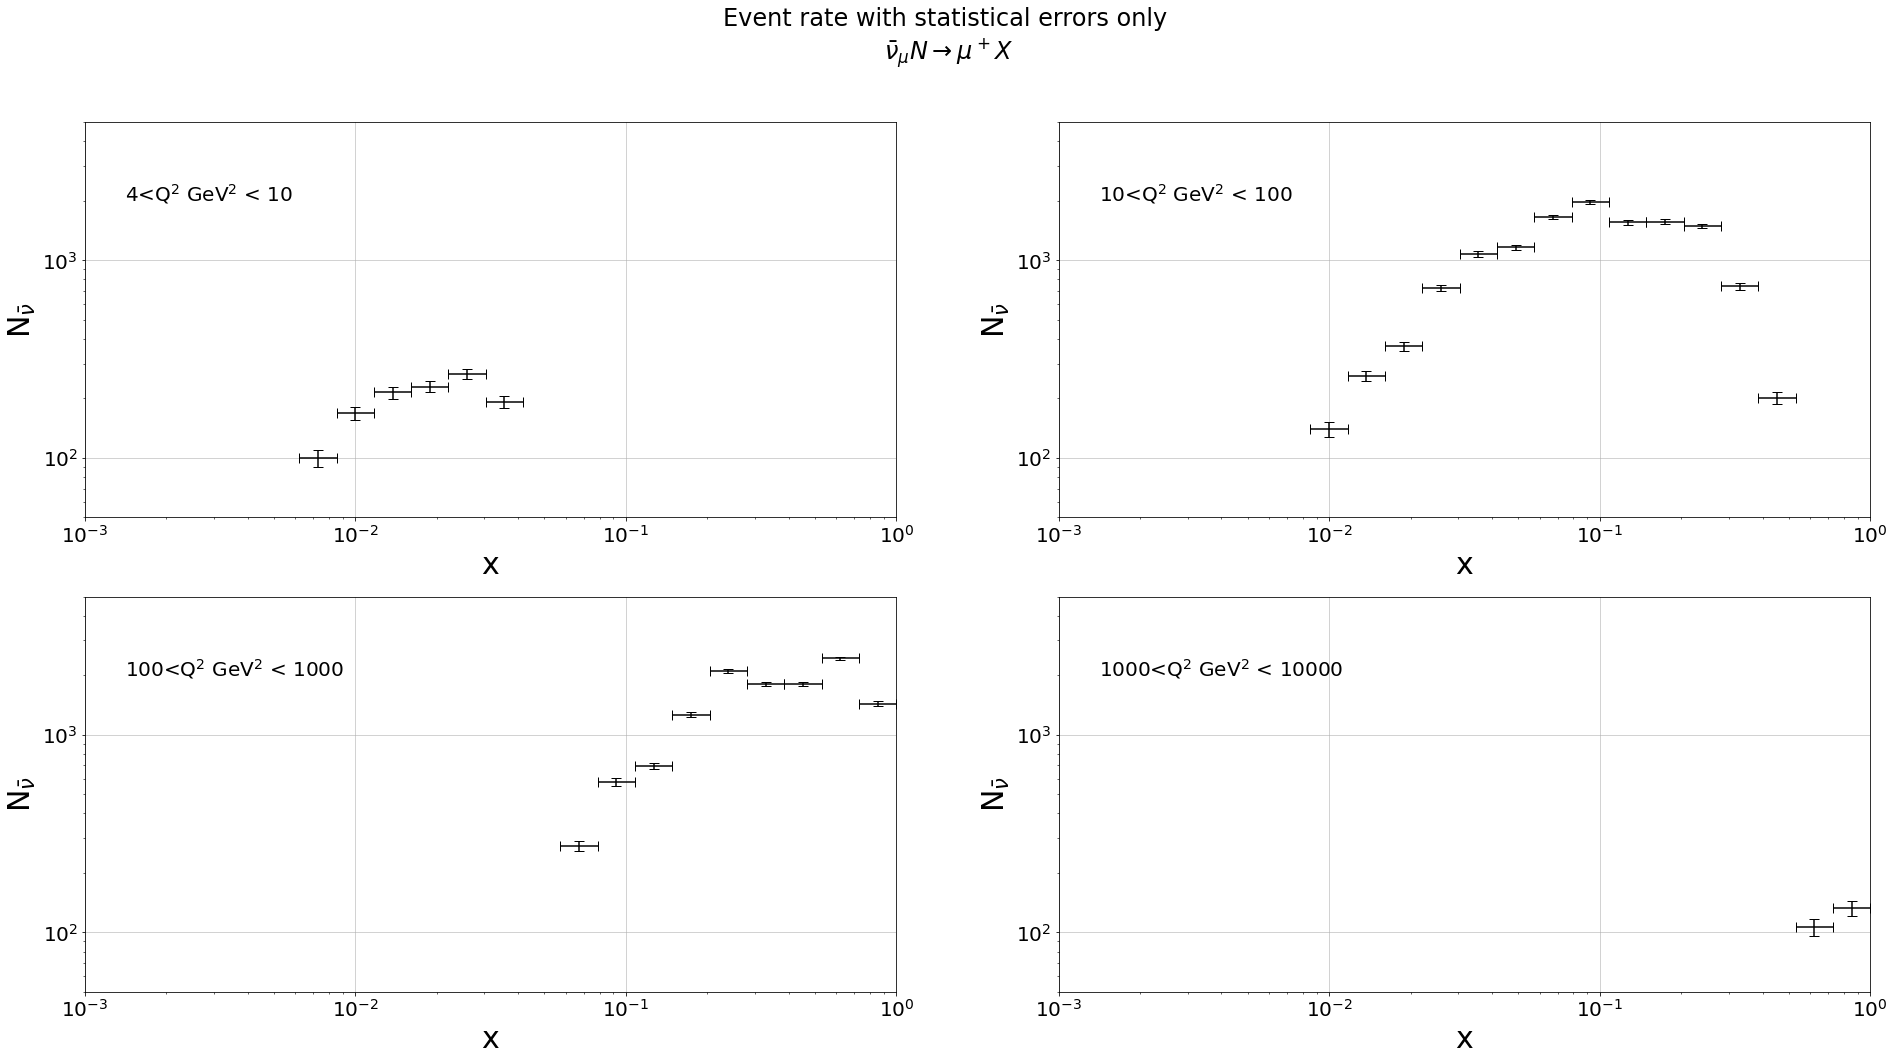

In [166]:
#make event plots
def make_plots(experiment,neutrino):
    neutrino_string = 'nu' if neutrino > 0 else 'nub'
    import matplotlib
    csfont = {"size" : 20}
    matplotlib.rc('font', **csfont)
    file = os.path.join(os.getcwd() , 'INCLUSIVE',experiment,'clipped_nan','clipped_nan_binned_sysevents_FASERv2_inclusive_%s.txt' %neutrino_string)
    if neutrino < 0:
        neutrino_string_label = r'\bar{\nu}'
    else:
        neutrino_string_label = r'\nu'
        
    process = get_string_process(neutrino)

    x_lower , x_upper , xavg , q2_lower , q2_upper , q2avg , _ , _ , _ , _ , N_array , stat_error , _ , _ , _ , _,_ =\
    file_reader(experiment,file)
    fig , AX = plt.subplots(2,2,figsize = (32,16))
    plot_locs = [[0,0],[0,1],[1,0],[1,1]]
    q2_regions = [[4 , 1e1],[10,1e2],[1e2,1e3],[1e3,1e4]]
    for (iq,q2_region),plot_loc in zip(enumerate(q2_regions),plot_locs):
        ax = AX[plot_loc[0],plot_loc[1]]
        locs = np.where((q2_lower >= q2_region[0]) & (q2_upper<=q2_region[1]))
        x_plot = np.exp((np.log(x_lower[locs[0]])+np.log(x_upper[locs[0]]))/2)
        q2_plot = np.exp((np.log(q2_lower[locs[0]])+np.log(q2_upper[locs[0]]))/2)
        x_ploterr_lower = x_plot - x_lower[locs[0]]
        x_ploterr_upper = x_upper[locs[0]] - x_plot
        x_ploterr = [x_ploterr_lower,x_ploterr_upper]
        ax.errorbar(x_plot , N_array[locs[0]],xerr = x_ploterr,yerr = stat_error[locs[0]],linestyle = 'none',color = 'black',capsize = 5)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.text(0.05,0.8,'%1.0f<Q$^2$ GeV$^2$ < %1.0f' %(q2_region[0],q2_region[1]),transform = ax.transAxes)
        ax.set_xlabel('x',fontsize = 30)
        ax.set_ylabel(r'N$_{%s}$' %neutrino_string_label,fontsize = 30)
        ax.grid(alpha = 0.7)
        ax.set_xlim(1e-3,1)
        ax.set_ylim(0.5e2,5e3)
        
    title = 'Event rate with statistical errors only \n' + process
    fig.suptitle(title)
    
    stringsave = os.path.join(os.getcwd() , 'INCLUSIVE','plots','staterrors_%s_%s.pdf' %(experiment,neutrino_string))
    plt.savefig(stringsave)
make_plots('FASERv2',-14)
    


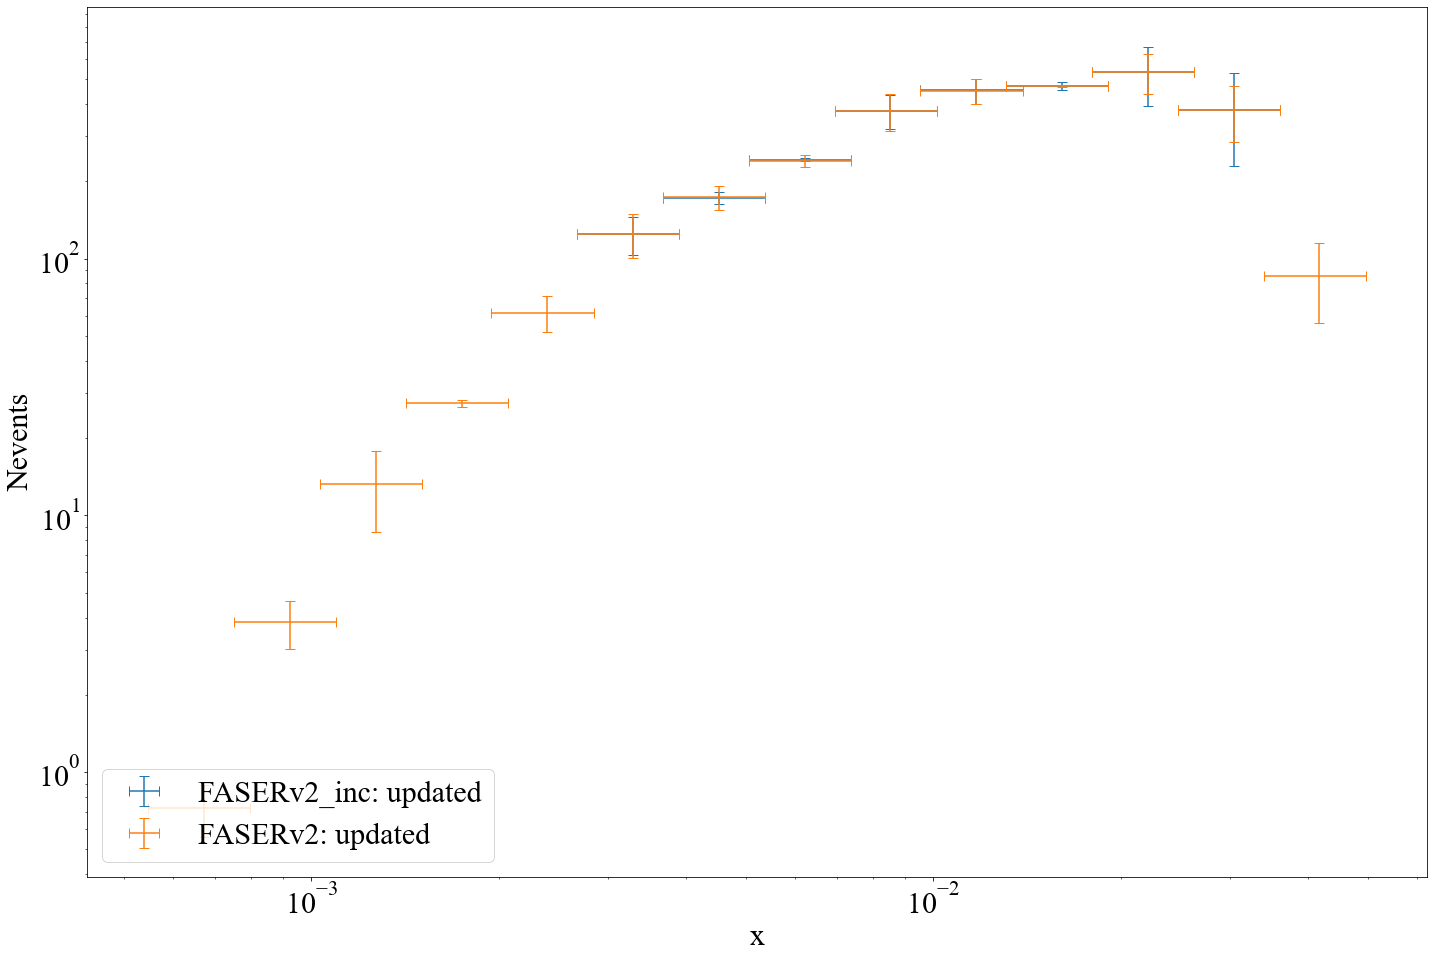

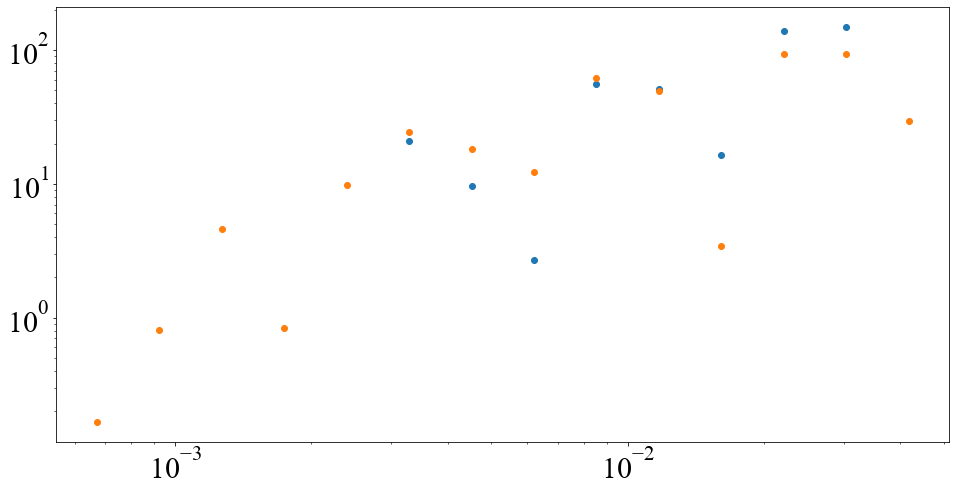

In [267]:
def plot():
    plt.rcParams["font.family"] = "Times New Roman";plt.rcParams["font.size"] = 30

    experiment = 'FASERv2';neutrino = 14;


    q2min = 4;q2max = 10;
    file_array = [ os.path.join(os.getcwd(),'INCLUSIVE','FASERv2','clipped_nan','clipped_nan_binned_sysevents_FASERv2_inclusive_nu.txt'),\
                os.path.join(os.getcwd(),'version2','FASERv2_optimistic','clipped_nan','clipped_nan_binned_sysevents_FASERv2_optimistic_nu.txt')]
    fig , ax = plt.subplots(1,1,figsize = (24,16));
    label_array = ['FASERv2_inc: updated','FASERv2: updated']

    for iif , file in enumerate(file_array):
        x_lower_array , x_upper_array , xavg , q2_lower_array , q2_upper_array , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N_array , stat_error , sys_error,_,_,_ , MCsamples =\
        file_reader(experiment,os.path.join(os.getcwd() , 'version2' , experiment , 'clipped_nan' , file))
        locs_above = np.where(q2_lower_array >= q2min)[0];locs_below = np.where(q2_upper_array <= q2max)[0];
        locs = list(set(locs_above) & set(locs_below))

        N_plot = N_array[locs];x_plot = x_lower_array[locs];sys_plot = sys_error[locs];stat_plot = stat_error[locs]


        x_ploterr = (x_upper_array[locs]-x_plot)/2
        ax.errorbar(x_plot , N_plot, yerr = sys_plot , xerr = x_ploterr, label = label_array[iif],ls = '',capsize = 5,alpha = 1)
        x_plot0 , N_plot0 = np.copy(x_plot) , np.copy(N_plot)
        ax.set_xscale('log')
        ax.set_yscale('log')
        Ncheck = np.copy(N_array)
        if iif == 0:
            sys1 = sys_error[locs]
            x1 = x_lower_array[locs]
        else:
            sys2 = sys_error[locs]
            x2 = x_lower_array[locs]
        
    ax.legend(loc = 'lower left')

    ax.set_xscale('log');
    ax.set_xlabel('x')
    ax.set_ylabel('Nevents')

#     ax.text(1e-3 , np.mean(N_plot) , '%1.0f < Q^2 < %1.0f' %(q2min , q2max))
#     ax.set_xlim(0.e-3 , 1)
    plt.figure(figsize = (16,8))
    plt.scatter(x1,sys1)
    plt.scatter(x2,sys2)
    plt.yscale('log')
    plt.xscale('log')
plot()

In [22]:
def check():
    N = 10000
    x_test = np.random.normal(loc = 5 , scale = 1 , size = N)
    print(len(x_test[x_test<5]) / len(x_test))
check()

0.4954


# Debugging below here

In [43]:
def check():
    experiment = 'FASERv2'
    file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_inclusive_nochargediscrimination.npy'
    M1 = np.load(file)
    print(file , np.shape(M1))
    file = 'version2\\FASERv2\\clipped_nan\clipped_nan_covariance_FASERv2_nochargediscrimination.npy'
    M2 = np.load(file)
    print(file , np.shape(M2))
    ###########################
    
    file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_nu.npy'
    M = np.load(file)
    print(file , np.shape(M))
    file = 'version2\\FASERv2\\clipped_nan\clipped_nan_covariance_FASERv2_nu.npy'
    M = np.load(file)
    print(file,np.shape(M))
    ##########################

    
    
    file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_nub.npy'
    M = np.load(file)
    print(file , np.shape(M))
    file = 'version2\\FASERv2\\clipped_nan\clipped_nan_covariance_FASERv2_nochargediscrimination.npy'
    M = np.load(file)
    print(file,np.shape(M))

    #########################
    
    
    print(sum(np.isnan(M)))
    name = os.path.join(os.getcwd(),'version2', 'FASERv2' ,'clipped_nan','clipped_nan_binned_sysevents_FASERv2_nochargediscrimination.txt' )
    x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , MCsamples = file_reader(experiment,name,smear_corr = '')

    print(len(x_plot))
check()

\Users\Mhfie\Downloads\clipped_nan_covariance_FASERv2_inclusive_nochargediscrimination.npy (55, 55)
version2\FASERv2\clipped_nan\clipped_nan_covariance_FASERv2_nochargediscrimination.npy (55, 55)
\Users\Mhfie\Downloads\clipped_nan_covariance_FASERv2_nu.npy (56, 56)
version2\FASERv2\clipped_nan\clipped_nan_covariance_FASERv2_nu.npy (56, 56)
\Users\Mhfie\Downloads\clipped_nan_covariance_FASERv2_nub.npy (55, 55)
version2\FASERv2\clipped_nan\clipped_nan_covariance_FASERv2_nochargediscrimination.npy (55, 55)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


NameError: name 'experiment' is not defined

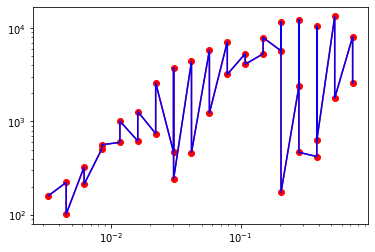

In [55]:
def check():
    experiment = 'FASERv2'
    file = os.path.join('INCLUSIVE','FASERv2','nan_binned_sysevents_FASERv2_inclusive_nu.txt')
    x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , Nnu , stat_error , sys_error , frac_sys , frac_sys_theta , frac_sys_Elepton , frac_sys_Ehadron , MCsamples = file_reader(experiment,file)

    
    file = os.path.join('INCLUSIVE','FASERv2','nan_binned_sysevents_FASERv2_inclusive_nub.txt')
    x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , Nnub , stat_error , sys_error , frac_sys , frac_sys_theta , frac_sys_Elepton , frac_sys_Ehadron , MCsamples = file_reader(experiment,file)
    
    Ntotal = Nnu + Nnub
    sys_error
    plt.plot(x_lower[Ntotal>100],Ntotal[Ntotal>100],'ro-')
    
    

    
    sys_errortotal = np.sqrt(sys_error_nu**2 + sys_error_nub**2)
    
    frac_sys_total = np.sqrt( (Nnu[locs]*frac_sys_nu[locs])**2 +  (Nnub[locs]*frac_sys_nub[locs])**2) / Ntotal[locs]
    
    frac_sys_theta_total =   np.sqrt(   (Nnu[locs]*frac_sys_theta_nu[locs])**2 +   (Nnub[locs]*frac_sys_theta_nub[locs])**2) / Ntotal[locs]
    frac_sys_Elepton_total = np.sqrt(   (Nnu[locs]*frac_sys_Elepton_nu[locs])**2 + (Nnub[locs]*frac_sys_Elepton_nub[locs])**2) / Ntotal[locs]
    frac_sys_Ehadron_total = np.sqrt(   (Nnu[locs]*frac_sys_Ehadron_nu[locs])**2 + (Nnub[locs]*frac_sys_Elepton_nub[locs])**2) / Ntotal[locs]
    
    
    file = os.path.join('INCLUSIVE','FASERv2','clipped_nan','clipped_nan_binned_sysevents_FASERv2_inclusive_nochargediscrimination.txt')
    x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , frac_sys , frac_sys_theta , frac_sys_Elepton , frac_sys_Ehadron , MCsamples = file_reader(experiment,file)
    locs = (~np.isnan(xavg)) & (N > 100)
    
    plt.plot(x_lower,N,'b-')
    
    
    plt.yscale('log')
    plt.xscale('log')
    
check()

In [72]:
def check():
    # file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_inclusive_nochargediscrimination.npy'
#     file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_inclusive_nochargediscrimination.npy'
#     file = file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_nu.npy'
#     file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_nu.npy'
    file = 'INCLUSIVE\\FASERv2\\clipped_nan\\clipped_nan_covariance_FASERv2_inclusive_nu.npy'
#     file = 'INCLUSIVE\\FASERv2\\clipped_nan\\clipped_nan_covariance_FASERv2_nub.npy'

    print(file)
    M1 = np.load(file)
    # print(file , np.shape(M1))
#     file = 'version2\\FASERv2\\clipped_nan\clipped_nan_covariance_FASERv2_nu.npy'
    file = 'version2\\FASERv2\\clipped_nan\clipped_nan_covariance_FASERv2_nochargediscrimination.npy'
    print(file)
    M2 = np.load(file)
    loc = np.where(M1 - M2 == np.max(M1 - M2))
    print(M1==M2)
    print(np.max(M1-M2),M1[loc] , M2[loc])
    index = 50
    plt.figure(figsize = (16,8))
    plt.plot(M1[:,index])
    plt.plot(M2[:,index],linestyle = 'dashed')
    # print(np.shape(M1) , np.shape(M2) )
    # fig , ax = plt.subplots(1,2,figsize = (16,8))
    # ax[0].imshow(M1);ax[1].imshow(M2)

    plt.figure(figsize = (16,8))

    file_prototype = 'clipped_nan_binned_sysevents_FASERv2_inclusive_nub.txt'

    file_inc = os.path.join('INCLUSIVE','FASERv2','clipped_nan',file_prototype)
    file_inc = '\\Users\\Mhfie\\Downloads\\' + file_prototype
    print(file_inc)
    x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , MCsamples = file_reader('FASERv2',file_inc,smear_corr = '')
#     plt.loglog(x_plot , N,linewidth = 5)
    plt.errorbar(x_plot,N , yerr = sys_error)
    a , b , c ,d = np.copy(diffxsec) , np.copy(N), np.copy(stat_error) , np.copy(sys_error) 
    length = len(x_plot);inc_error = np.copy(sys_error)

    file_prototype = file_prototype.split('_');file_prototype = '_'.join(file_prototype[0:5]) + '_' + '_'.join(file_prototype[6:9])
    file = os.path.join('version2','FASERv2','clipped_nan',file_prototype)
    print(file)
    x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , MCsamples = file_reader('FASERv2',file,smear_corr = '')
#     plt.loglog(x_plot , N,linestyle = 'dotted',linewidth = 3)
    plt.errorbar(x_plot,N , yerr = sys_error)
    plt.yscale('log')
    print('##')
#     print(a,diffxsec)
    print(a - diffxsec,b - N,c-stat_error , d-sys_error)
#     print(length,len(x_plot))
#     print(sys_error ==inc_error)
check()

INCLUSIVE\FASERv2\clipped_nan\clipped_nan_covariance_FASERv2_inclusive_nochargediscrimination.npy
version2\FASERv2\clipped_nan\clipped_nan_covariance_FASERv2_nochargediscrimination.npy


ValueError: operands could not be broadcast together with shapes (30,30) (55,55) 

40949.61466590308 273734.44593480736
24691929.406421743
(30, 30)


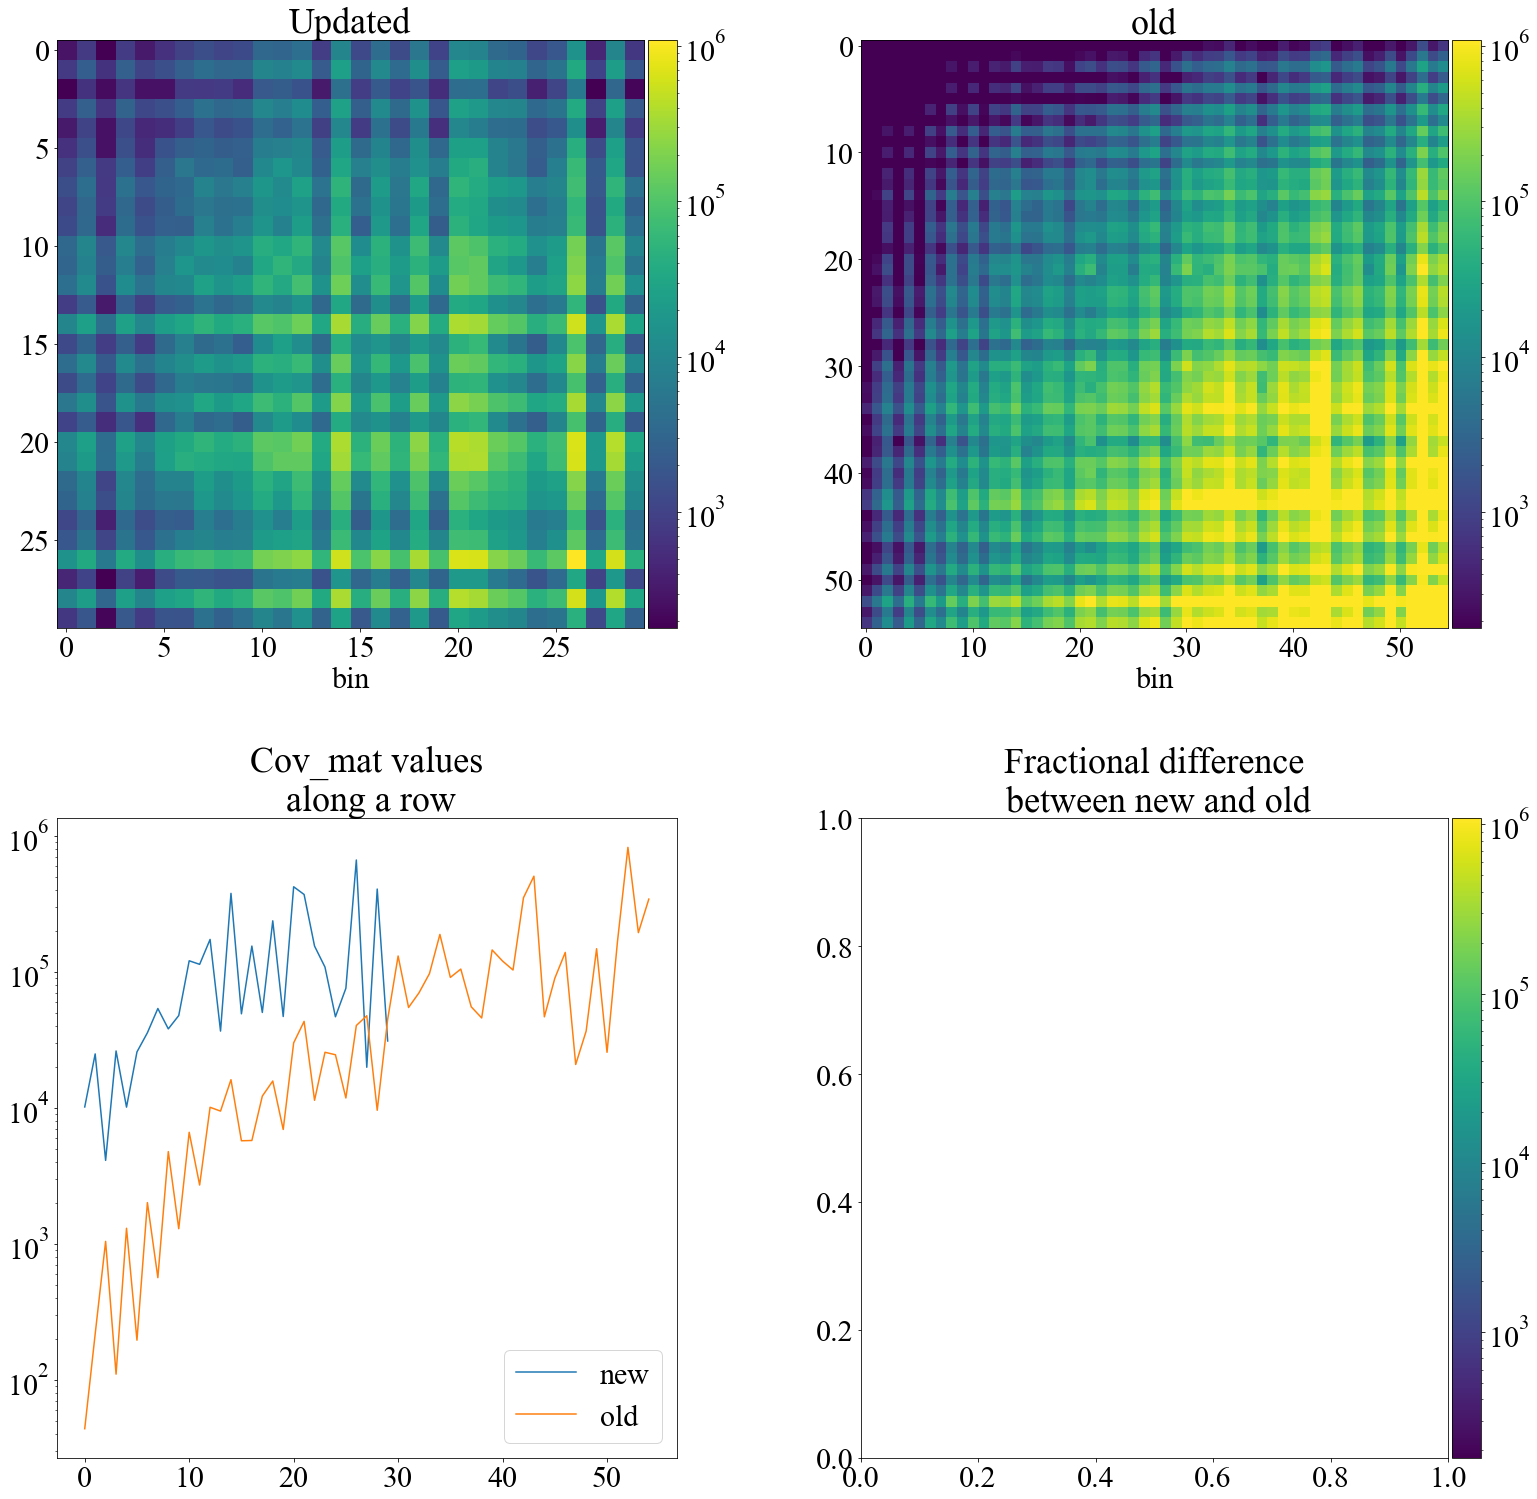

In [393]:
def check():
    # file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_inclusive_nochargediscrimination.npy'
#     file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_inclusive_nochargediscrimination.npy'
#     file = file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_nu.npy'
#     file = '\\Users\\Mhfie\Downloads\\clipped_nan_covariance_FASERv2_nu.npy'
    file = 'INCLUSIVE\\FASERv2\\clipped_nan\\clipped_nan_covariance_FASERv2_inclusive_nub.npy'
#     file = 'INCLUSIVE\\FASERv2\\clipped_nan\\clipped_nan_covariance_FASERv2_inclusive_nu.npy'
    M = np.load(file)
    fig , ax = plt.subplots(2,2,figsize = (24,24))
    fig.tight_layout(pad = 4)
    im = ax[0,0].imshow(M,norm = colors.LogNorm(vmin = np.min(M) , vmax = np.max(M)));
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im,cax = cax)
    
#     file = os.path.join('INCLUSIVE','FASERv2','clipped_nan','clipped_nan_smear_FASERv2_inclusive_nub_Elepton.txt')
#     x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error_elepton , MCsamples = file_reader('FASERv2',file,smear_corr = '')
    
#     file = os.path.join('INCLUSIVE','FASERv2','clipped_nan','clipped_nan_smear_FASERv2_inclusive_nub_Ehadron.txt')
#     x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error_ehadron , MCsamples = file_reader('FASERv2',file,smear_corr = '')
    
#     file = os.path.join('INCLUSIVE','FASERv2','clipped_nan','clipped_nan_smear_FASERv2_inclusive_nub_theta.txt')
#     x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error_theta , MCsamples = file_reader('FASERv2',file,smear_corr = '')
#     print('##')
#     print(sys_error_elepton**2 + sys_error_ehadron**2 + sys_error_theta**2)
    
    i_select,j_select = 20,11

    file = '\\Users\\Mhfie\\Downloads\\clipped_nan_covariance_FASERv2_inclusive_nochargediscrimination.npy'
    Mold = np.load(file)
    im = ax[0,1].imshow(Mold,norm = colors.LogNorm(vmin = np.min(M) , vmax = np.max(M)))
    divider = make_axes_locatable(ax[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im,cax = cax)

    ax[1,0].plot(M[i_select,:],label = 'new')
    ax[1,0].plot(Mold[i_select,:],label = 'old')
    
    ax[1,0].legend()
    ax[1,0].set_yscale('log')
    if np.shape(M)==np.shape(Mold):
        im = ax[1,1].imshow(np.abs((M - Mold) / Mold),norm = colors.LogNorm(vmin = 1e-1 , vmax = 100))
        print(M[i_select,:] - Mold[i_select,:])
        print(np.min((M - Mold) / Mold) , np.max((M - Mold) / Mold))

    divider = make_axes_locatable(ax[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im,cax = cax)

#     print(np.mean(M),np.mean(Mold))
    ax[0,0].set_title('Updated');ax[0,1].set_title('old')
    ax[0,0].set_xlabel('bin');ax[0,1].set_xlabel('bin')
    ax[1,0].set_title(' \n Cov_mat values \n along a row');ax[1,1].set_title(' \n Fractional difference \n between new and old')
    
    print(np.mean(M) , np.mean(Mold))
    print(np.max(Mold))
    print(np.shape(M))
check()

38


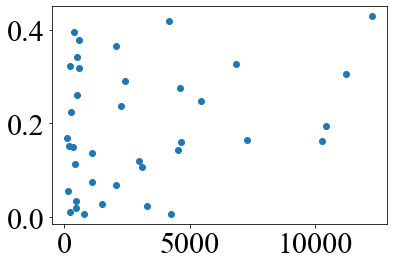

In [389]:
def check():
    file = os.path.join('INCLUSIVE','FASERv2','clipped_nan','clipped_nan_binned_sysevents_FASERv2_inclusive_nu.txt')
    x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error_me , MCsamples = file_reader('FASERv2',file,smear_corr = '')
    plt.scatter(N,sys_error_me / N)
#     plt.yscale('log')
    print(len(x_plot))

check()

In [ ]:
def plot():
    plt.rcParams["font.family"] = "Times New Roman";plt.rcParams["font.size"] = 30

    experiment = 'FASERv2';neutrino = 14;

    name = os.path.join(os.getcwd() , 'version2' , experiment ,'nan_binned_sysevents_FASERv2_nu.txt' )
    x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , MCsamples = file_reader(experiment,name,smear_corr = '')

    #sum in certain q range
    q2min = 1e2;q2max = 1e3
    locs_above = np.where(q2_lower >= q2min)[0];locs_below = np.where(q2_upper <= q2max)[0];
    locs = list(set(locs_above) & set(locs_below))

    N_plot = N[locs];x_plot = x_lower[locs];sys_plot = sys_error[locs];stat_plot = stat_error[locs]
    fig , ax = plt.subplots(1,2,figsize = (22,8));
    N_plot_new = np.copy(N)

    x_ploterr = (x_upper[locs]-x_plot)/2
    ax[0].errorbar(x_plot , N_plot, yerr = sys_plot , xerr = x_ploterr, label = 'FASER2:new',ls = 'none',capsize = 5)
    x_plot0 , N_plot0 = np.copy(x_plot) , np.copy(N_plot)
    ax[0].set_xscale('log')
    # ax[0].set_yscale('log')
    print(len(x_lower[locs]))
    experiment = 'FASERv2'
    name = os.path.join(os.getcwd(),'version2', experiment ,'clipped_nan','clipped_nan_binned_sysevents_FASERv2_nu.txt' )
    x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , MCsamples = file_reader(experiment,name,smear_corr = '')

    #sum in certain q range
    locs_above = np.where(q2_lower >= q2min)[0];locs_below = np.where(q2_upper <= q2max)[0];
    locs = list(set(locs_above) & set(locs_below))
    #sum over multiple x's
    x_ploterr = (x_upper[locs]-x_plot[locs])/2

    N_plot = N[locs];x_plot = x_lower[locs];sys_plot = sys_error[locs];stat_plot = stat_error[locs]


    # ax[0].scatter(x_plot , N_plot,label='old')
    # ax[0].errorbar(x_plot , N_plot, yerr = sys_plot , xerr = x_ploterr, label = 'FASER2_optimistic:new',ls = 'none',capsize = 5)
    ####
    experiment = 'FASERv2'
    name = os.path.join(os.getcwd(), experiment ,'binned_sysevents_FASERv2_14.txt' )
    x_plot , x_upper , xavg , q2_lower, q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error , MCsamples = file_reader(experiment,name,smear_corr = '')

    #sum in certain q range
    locs_above = np.where(q2_lower >= q2min)[0];locs_below = np.where(q2_upper <= q2max)[0];
    locs = list(set(locs_above) & set(locs_below))
    #sum over multiple x's
    x_ploterr = (x_upper[locs]-x_plot[locs])/2

    N_plot = N[locs];x_plot = x_lower[locs];sys_plot = sys_error[locs];stat_plot = stat_error[locs]


    # ax[0].scatter(x_plot , N_plot,label='old')
    ax[0].errorbar(x_plot , N_plot, yerr = sys_plot , xerr = x_ploterr, label = 'FASER2:old',ls = 'none',capsize = 5)

    ###
    ax[0].legend()

    ax[1].scatter(x_plot , N_plot / N_plot0)
    ax[0].set_xscale('log');ax[1].set_xscale('log')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('Nevents')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel(r'Faser2 Event Rate: $\frac{\rm old}{\rm new}$ ')
    # ax[1].set_yscale('log')
    ax[1].set_ylim(0.3 , 2)
    ax[0].text(1e-4 , np.mean(N_plot) , '%1.0f < Q^2 < %1.0f' %(q2min , q2max))
    # ax[0].set_xlim(1e-2 , 1)
plot()

Were experimental cuts made? 1
Acceptance rate and count: 0.0104918 104918


C:\Users\Mhfie\AppData\Local\Temp/ipykernel_30784/2823719735.py:138: RuntimeWarning: invalid value encountered in arcsin
  sin2_theta_2 = q2 / (4 * Enu * Elepton);theta = 2 * np.arcsin(np.sqrt(sin2_theta_2))


Were experimental cuts made? 1
Acceptance rate and count: 0.0105137 105137
Were experimental cuts made? 1
Acceptance rate and count: 0.0105352 105352
Were experimental cuts made? 1
Acceptance rate and count: 0.0105655 105655
Were experimental cuts made? 1
Acceptance rate and count: 0.0104701 104701
441902 0.25909307875894994
Were experimental cuts made? 1
Acceptance rate and count: 0.0104215 104215
Were experimental cuts made? 1
Acceptance rate and count: 0.0105612 105612
Were experimental cuts made? 1
Acceptance rate and count: 0.0105482 105482
Were experimental cuts made? 1
Acceptance rate and count: 0.0104645 104645
Were experimental cuts made? 1
Acceptance rate and count: 0.0104844 104844
453666 0.31972017394592556


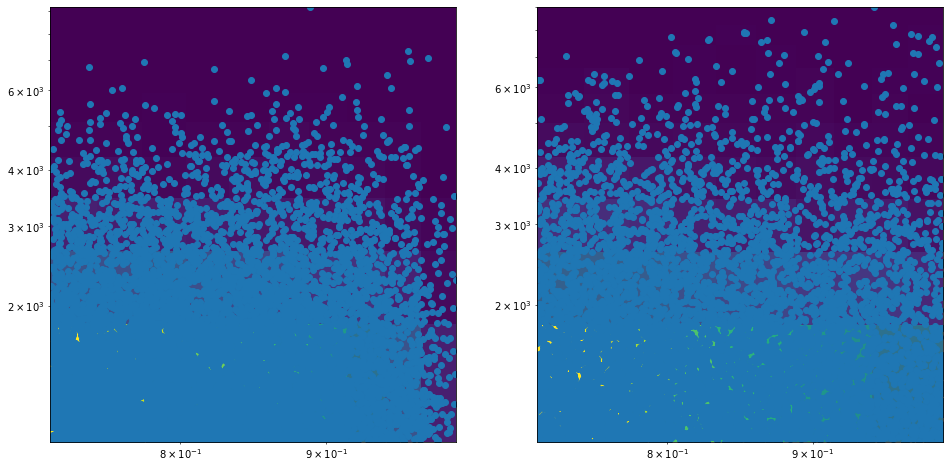

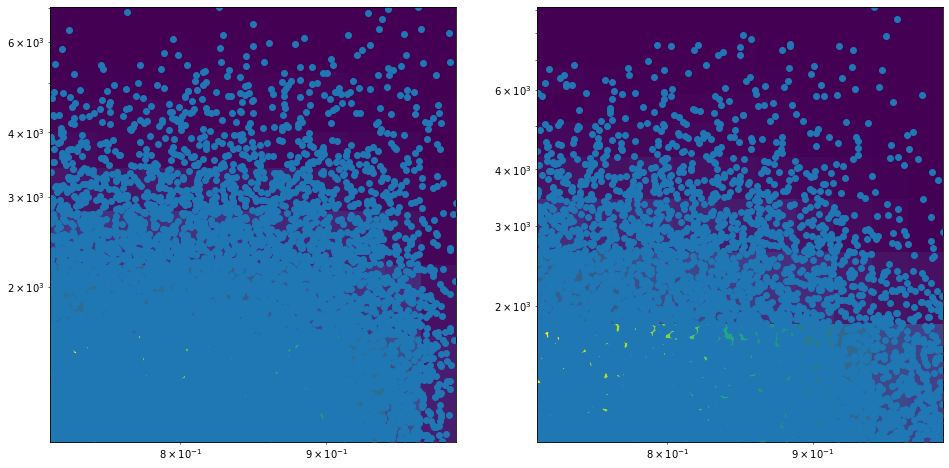

In [105]:
def check(smear_corr):
    experiment = 'FASERv2'
    x , q2 , Enu = sample_space(experiment , 14 ,Nloops = 5  , makecuts = 1)
    x_smear , q2_smear , Enu_smear = smear_obs_from_kin(experiment , 14 , x , q2 , Enu,smear_corr = smear_corr)
    x_smear , q2_smear , Enu_smear = make_all_cuts(experiment,14,x_smear,q2_smear,Enu_smear)
#     x_smear , q2_smear , Enu_smear = make_exp_cuts_from_kin(experiment,14,x_smear , q2_smear , Enu_smear)
#     x_smear , q2_smear , Enu_smear = make_cuts(x_smear , q2_smear , Enu_smear)


    #plotting
    
    fig,ax = plt.subplots(1,2,figsize = (16,8))
#     ax[0].scatter(x,q2);ax[0].set_xscale('log');ax[0].set_yscale('log')
#     ax[1].scatter(x_smear,q2_smear);ax[1].set_xscale('log');ax[1].set_yscale('log');ax[1].set_xlim(ax[0].get_xlim());ax[1].set_ylim(ax[0].get_ylim())
    
    x_bin = [0.72,1];q2_bin = [1e3,1e4];Enu_bin = [10,5700]
    locs0 = get_kin_inside(x_bin , q2_bin , Enu_bin,x,q2,Enu)
    locs1 = get_kin_inside(x_bin , q2_bin , Enu_bin,x_smear,q2_smear,Enu_smear)
    
    ax[0].hist2d(locs0[0],locs0[1]);ax[0].set_xscale('log');ax[0].set_yscale('log');ax[0].scatter(locs0[0],locs0[1])
    ax[1].hist2d(locs1[0],locs1[1]);ax[1].set_xscale('log');ax[1].set_yscale('log');ax[1].scatter(locs1[0],locs1[1])
    print(len(x_smear),1- len(locs1[0]) / len(locs0[0]))
check('')
check('Ehadron')

Were experimental cuts made? 1
Acceptance rate and count: 0.010497 104970
104970 104970


C:\Users\Mhfie\AppData\Local\Temp/ipykernel_30784/2863183922.py:138: RuntimeWarning: invalid value encountered in arcsin
  sin2_theta_2 = q2 / (4 * Enu * Elepton);theta = 2 * np.arcsin(np.sqrt(sin2_theta_2))


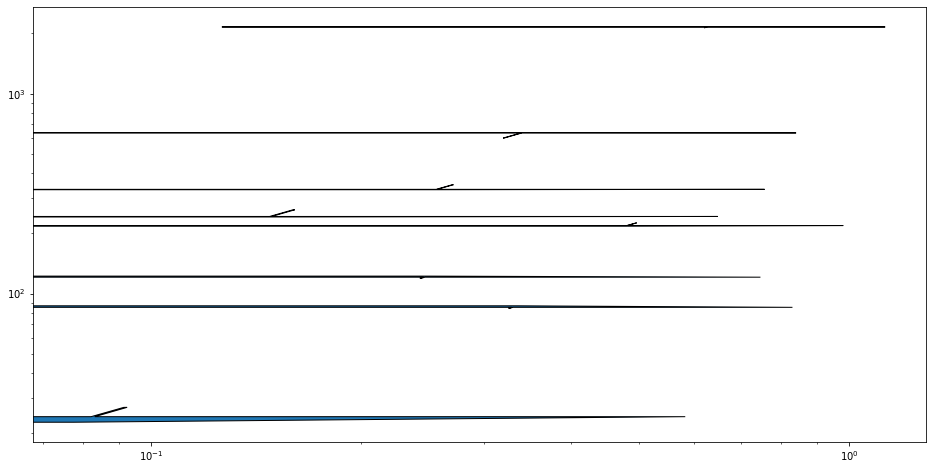

In [137]:
def check():
    x_bin = [0.72,1];q2_bin = [1e3,1e4];Enu_bin = [10,5700]

    experiment = 'FASERv2'
    xx , qq , Enu = sample_space(experiment , 14 ,Nloops = 1  , makecuts = 1)
#     xx , qq, Enu = get_kin_inside(x_bin , q2_bin , Enu_bin,xx,qq,Enu)
    
    plt.figure(figsize = (16,8))
    x_smear , q2_smear , Enu_smear = smear_obs_from_kin('FASERv2',14,xx,qq,Enu,smear_corr = 'theta')
#     x_smear , q2_smear , Enu_smear = get_kin_inside(x_bin , q2_bin , Enu_bin,x_smear,q2_smear,Enu_smear)
    
    print(len(xx),len(x_smear))
    for (ix,x),(iq,q) in zip(enumerate(xx),enumerate(qq)):
        dx = x_smear[ix]-x
        dy = q2_smear[iq] - q
        plt.arrow(x,q,dx,dy,head_width = 1)
        plt.xscale('log');plt.yscale('log')
        
        if ix==7:
            break
    
check()

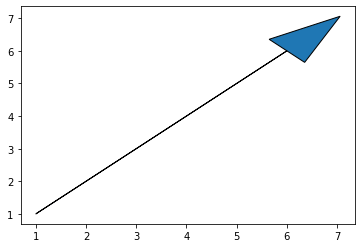

In [122]:
plt.arrow(1,1,5,5,head_width = 1)